In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

import torch
import torchvision
import cv2
from torchvision.transforms.functional import rotate, center_crop, resize
from albumentations import ElasticTransform, Compose, Blur
from albumentations.augmentations.geometric import functional as albu_geom
from albumentations.pytorch import ToTensorV2
import albumentations as A
import pytorch_lightning as pl
# import timm
from hydra.utils import instantiate

/home/jupyter/.local/lib/python3.10/site-packages/neptune/internal/backends/hosted_client.py:51: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
/home/jupyter/.local/lib/python3.10/site-packages/pytorch_lightning/loggers/neptune.py:51: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  import neptune.new as neptune


In [2]:
import skimage
from scipy.stats import circmean, circstd

In [3]:
from src import transforms, models

In [4]:
torch.set_grad_enabled(False)

## read annotations

In [5]:
radon_data_dir = Path('/scratch/projects/023/01_data/cropped/A/objects_skimageradon_size64_angles180/')

In [6]:
annotations = pd.read_csv('/scratch/projects/023/01_data/cropped/grana_20231028.csv')
annotations['object_filename'] = annotations['object_filename'].str.replace('.png', '.npy')
annotations = annotations.loc[annotations['readable']].reindex()
for col_name in ['granum_lumen_fraction', 'angle', 'period']:
    annotations[col_name] = annotations[col_name].astype('float')
annotations['period'] = annotations['period']*1.296 # from nm to pixels
annotations.head()

,object_filename,image_filename,object_idx,angle,hight,diameter_min,diameter_max,diameter_mean,layers_lumnen_fraction,granum_lumen_fraction,layers_number,period,readable_code,readable
0,27_hs8 [1]_0.npy,27_hs8 [1].png,0.0,-11.966,264.229,335.518,613.989,464.586466666667,5.498,0.292254,15,22.829386,2.0,True
1,27_hs8 [1]_1.npy,27_hs8 [1].png,1.0,-2.564,155.248,412.435,644.119,542.455555555556,10.149,0.344107,9,22.355712,2.0,True
2,27_hs8 [1]_2.npy,27_hs8 [1].png,2.0,-24.476,113.604,555.331,630.601,592.051666666667,8.627,0.361035,6,24.538464,2.0,True
3,27_hs8 [1]_3.npy,27_hs8 [1].png,3.0,-25.731,71.092,481.973,488.875,485.256,5.624,0.388679,4,23.033808,2.0,True
4,27_hs8 [1]_4.npy,27_hs8 [1].png,4.0,-25.663,219.148,358.438,613.339,457.120083333333,7.247,0.308458,12,23.667984,2.0,True


In [7]:
idx = 4
(radon_data_dir / annotations['object_filename'].iloc[idx]).is_file()

True

## Deep learning model

In [8]:
# list(data_dir.iterdir())

In [9]:
checkpoint_path = '/scratch/projects/023/06_periodicity/logs_radon_diffusion_byangle/version_21/checkpoints/epoch=39-val_loss=0.63.ckpt'

In [10]:
model = models.StripsModel.load_from_checkpoint(checkpoint_path)
model.eval();

In [12]:
idx = 0
row = annotations.iloc[idx]
batch = np.load(radon_data_dir / row['object_filename'])
#transpose angle and space to match skimage format
batch = np.transpose(batch, (0, 2, 1))

reshaped = np.transpose(skimage.transform.resize(np.transpose(batch, (1, 2, 0)), (128,128), anti_aliasing=True), (2, 0, 1))
reshaped -= np.min(reshaped, axis=(1,2),keepdims=True)
reshaped /= np.max(reshaped, axis=(1,2),keepdims=True)
reshaped = reshaped.astype('float32')

In [13]:
angles, periods, lumen_fraction = model(torch.tensor(reshaped).unsqueeze(1).cuda())
angles = angles.cpu().numpy()
periods = periods.cpu().numpy()
lumen_fraction = lumen_fraction.cpu().numpy()

In [16]:
# fig, axs = plt.subplots(ncols=3, figsize=(14,6))
# # angle
# axs[0].hist(angles+90)
# axs[0].axvline(circmean(angles,high=90,low=-90), c='C0')
# axs[0].axvline(row['angle'], c='k')
# axs[0].set_title('angle')
# # period
# axs[1].hist(periods)
# axs[1].axvline(float(row['period'])*1.296, c='k')
# axs[1].set_title('period')
# # lumen fraction
# axs[2].hist(lumen_fraction)
# axs[2].axvline(float(row['granum_lumen_fraction']), c='k')
# axs[2].set_title('lumen fraction')


In [18]:
file_path = radon_data_dir / annotations.iloc[0]['object_filename']

In [19]:
# batch = np.load(file_path)
# #transpose angle and space to match skimage format
# # batch = np.transpose(batch, (0, 2, 1))

# reshaped = np.transpose(skimage.transform.resize(np.transpose(batch, (1, 2, 0)), (128,128), anti_aliasing=True), (2, 0, 1))
# reshaped -= np.min(reshaped, axis=(1,2),keepdims=True)
# reshaped /= np.max(reshaped, axis=(1,2),keepdims=True)
# reshaped = reshaped.astype('float32')

In [21]:
# plt.imshow(reshaped[5])

In [22]:
def robust_mean(x, q=0.1):
    x_med = np.median(x)
    deviations = abs(x- x_med)
    if max(deviations) == 0:
        mask = np.ones(len(x), dtype='bool')
    else:
        threshold = np.quantile(deviations, 1-q)
        mask = x[deviations<= threshold]
     
    return np.mean(x[mask])
    

In [25]:
def calculate_preds(file_path, model):
    # create batch
    batch = np.load(file_path)
    #transpose angle and space to match skimage format
    # batch = np.transpose(batch, (0, 2, 1))
    
    reshaped = np.transpose(skimage.transform.resize(np.transpose(batch, (1, 2, 0)), (128,128), anti_aliasing=True), (2, 0, 1))
    reshaped -= np.min(reshaped, axis=(1,2),keepdims=True)
    reshaped /= np.max(reshaped, axis=(1,2),keepdims=True)
    reshaped = reshaped.astype('float32')

    # get predictions
    angles, periods, lumen_fraction = model(torch.tensor(reshaped).unsqueeze(1).cuda())
    angles = angles.cpu().numpy()
    periods = periods.cpu().numpy()
    lumen_fraction = lumen_fraction.cpu().numpy()

    return angles, periods, lumen_fraction

def make_plot(row, angles, periods, lumen_fraction):
    fig, axs = plt.subplots(ncols=3, figsize=(14,6))
    # angle
    axs[0].hist((angles + 180)%180)
    axs[0].axvline(circmean(angles,high=180,low=0), c='C0', label='True')
    axs[0].axvline(row['angle']% 180, c='k', label='predicted')
    axs[0].legend()
    axs[0].set_title('angle')
    # period
    axs[1].hist(periods)
    axs[1].axvline(np.median(periods), c='C0')
    axs[1].axvline(row['period'], c='k')
    axs[1].set_title('period')
    # lumen fraction
    axs[2].hist(lumen_fraction)
    axs[2].axvline(np.median(lumen_fraction), c='C0')
    axs[2].axvline(row['granum_lumen_fraction'], c='k')
    axs[2].set_title('lumen fraction')

    return fig, axs

def analyse_image(data_row, model=model, data_dir=radon_data_dir):
    file_path = data_dir / data_row['object_filename']

    angles, periods, lumen_fraction = calculate_preds(file_path, model)

    fig, axs = make_plot(data_row, angles, periods, lumen_fraction)

    preds_aggregated = {
        'angle': circmean(angles,high=90,low=-90),
        'period': np.median(periods),
        'lumen_fraction': np.median(lumen_fraction),
        'angle_std': circstd(angles,high=90,low=-90),
        'period_std': np.std(periods),
        'lumen_frac_std': np.std(lumen_fraction),
    }

    

    return dict(
        preds=preds_aggregated,
        preds_raw = dict(angles=angles, periods=periods, lumen_fraction=lumen_fraction),
        fig=dict(fig=fig, axs=axs)
    )
    


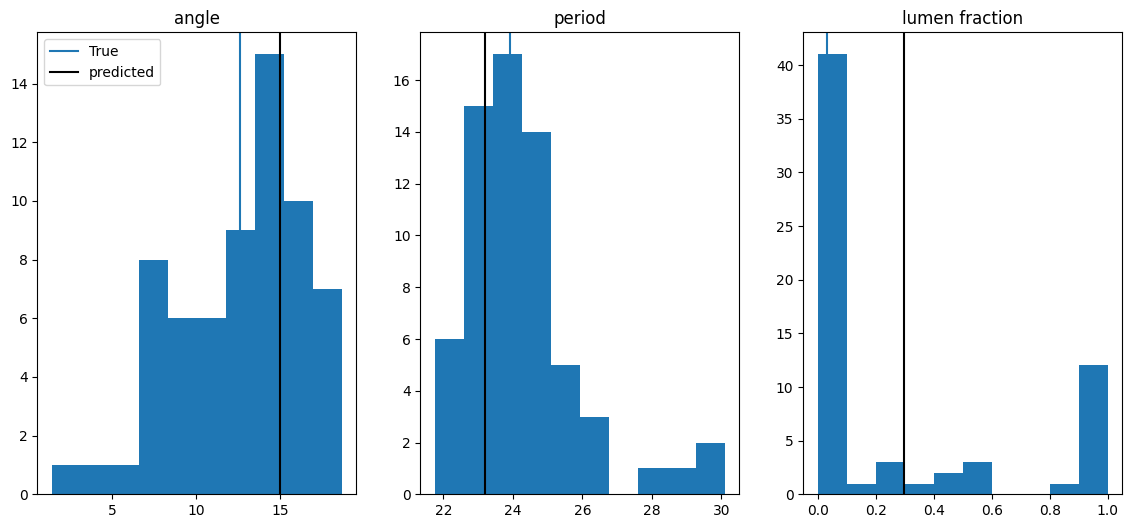

In [26]:
result = analyse_image(annotations.iloc[8])

In [28]:
def angle_difference(angles1, angles2):
    return np.rad2deg(0.5*np.arccos(np.cos(np.deg2rad(2*angles1 - 2*angles2))))

/tmp/ipykernel_343132/3644778875.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(ncols=3, figsize=(14,6))


38_k10[1]_0.npy
38_k10[1]_1.npy
38_k10[1]_2.npy
38_k10[1]_3.npy
38_k10[1]_4.npy
38_k10[1]_5.npy
38_k10[1]_6.npy
38_k10[1]_7.npy
38_k10[1]_8.npy
38_k10[1]_12.npy
38_k10[1]_13.npy
38_k10[1]_15.npy
38_k10[1]_16.npy
38_k42[1]_0.npy
38_k42[1]_1.npy
38_k42[1]_2.npy
38_k42[1]_3.npy
38_k42[1]_4.npy
38_k42[1]_5.npy
38_k42[1]_6.npy
38_k42[1]_7.npy
38_k42[1]_8.npy
38_k42[1]_9.npy
38_k42[1]_11.npy
38_k42[1]_12.npy
38_k42[1]_13.npy
38_k42[1]_14.npy
38_k42[1]_15.npy
38_k42[1]_16.npy
38_k42[1]_17.npy
38_k42[1]_18.npy
38_k42[1]_19.npy
38_k42[1]_20.npy
38_k42[1]_21.npy
38_k42[1]_22.npy


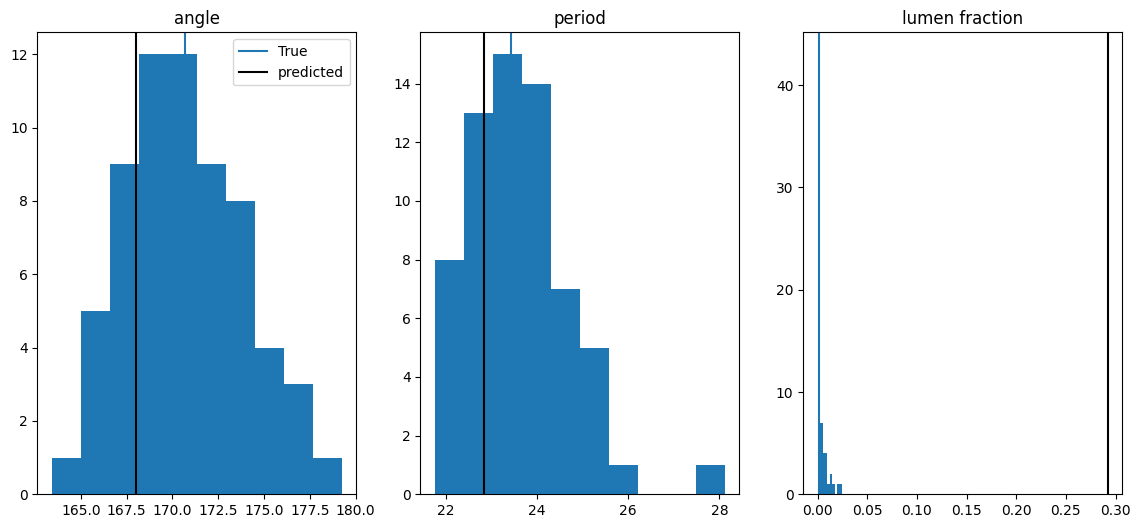

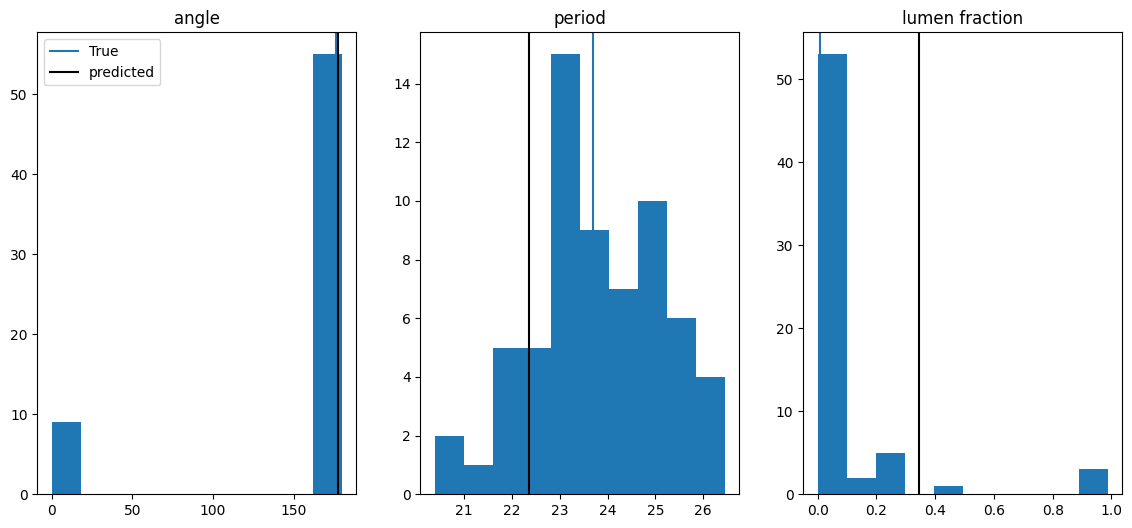

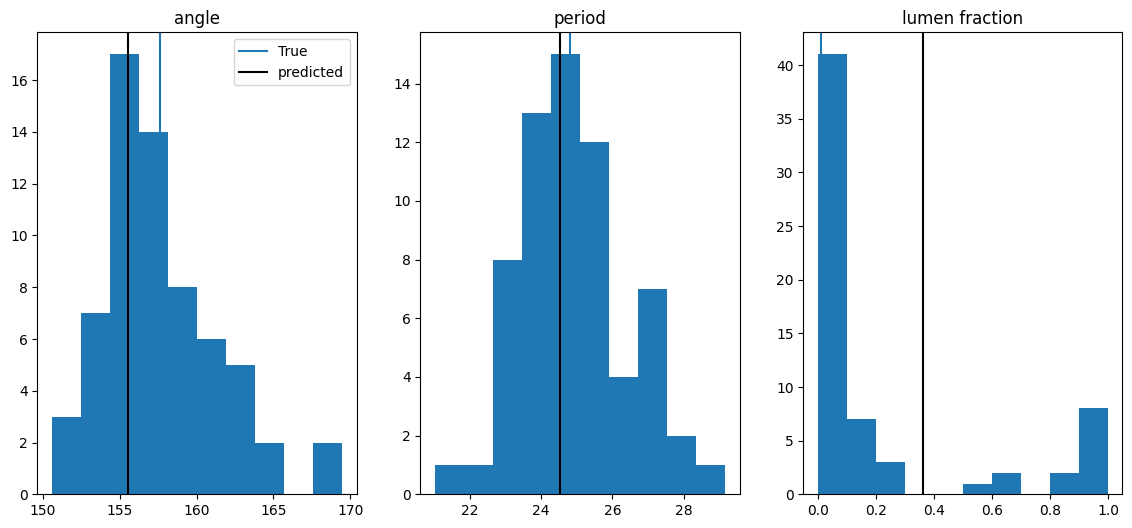

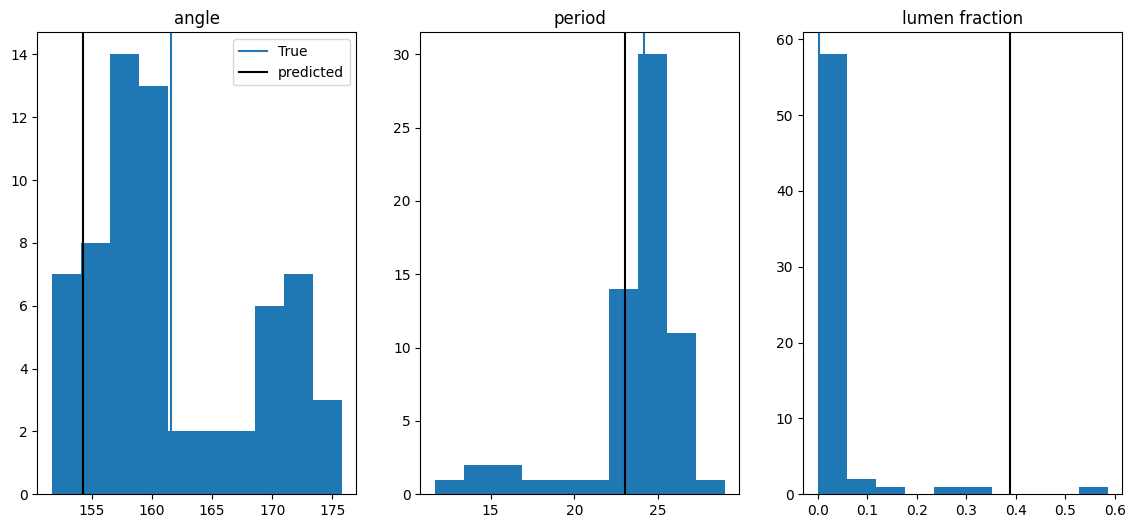

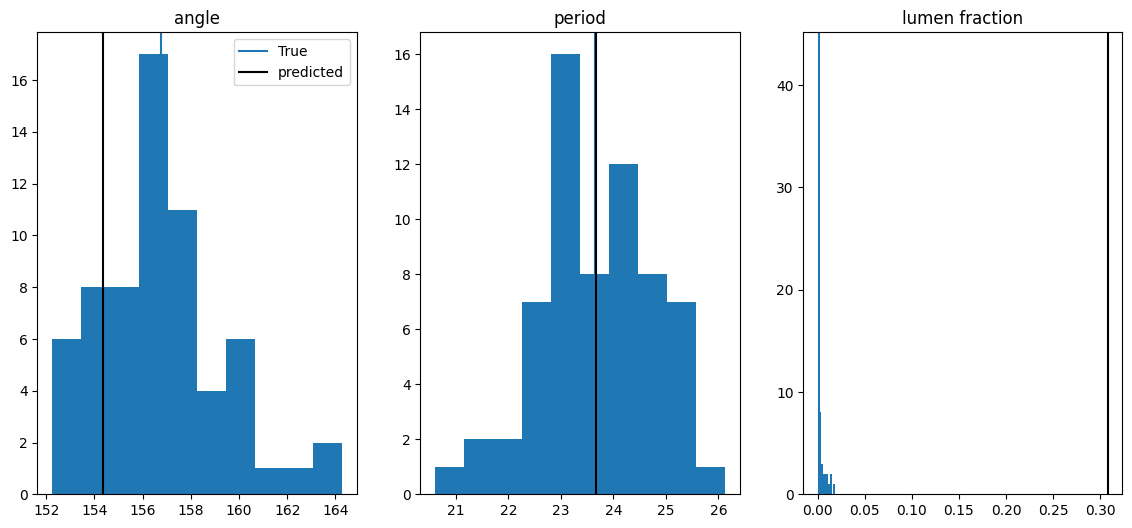

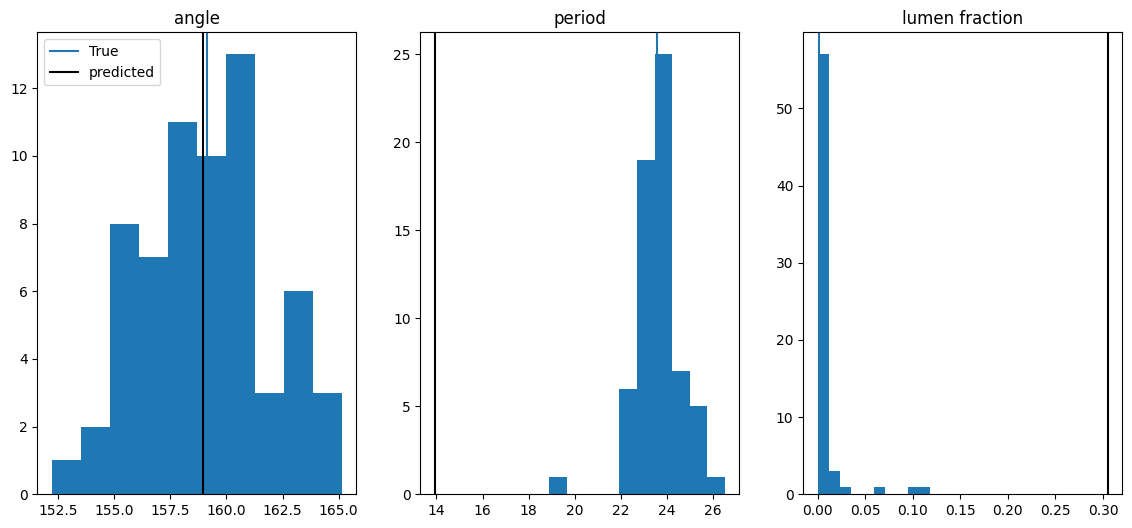

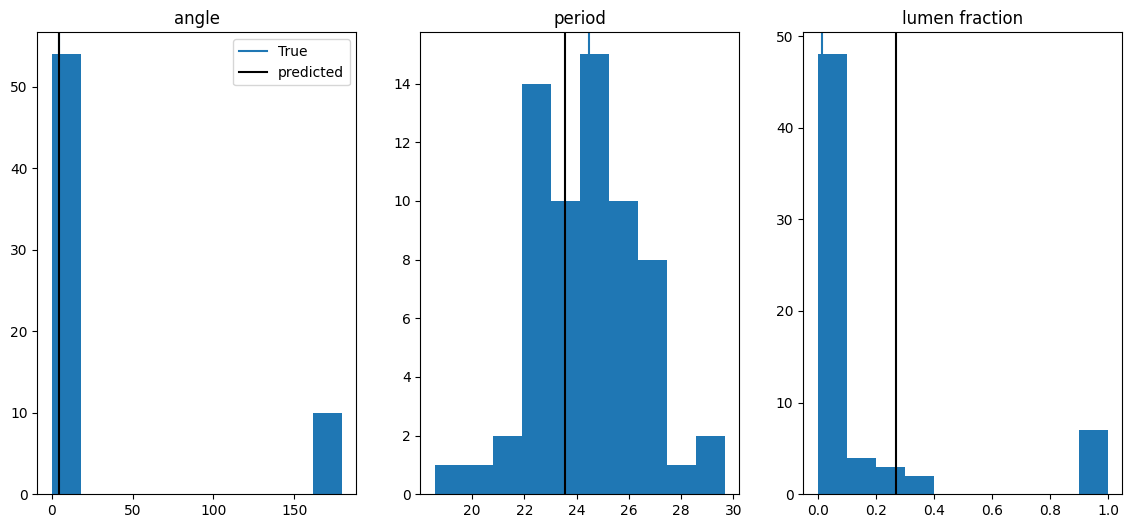

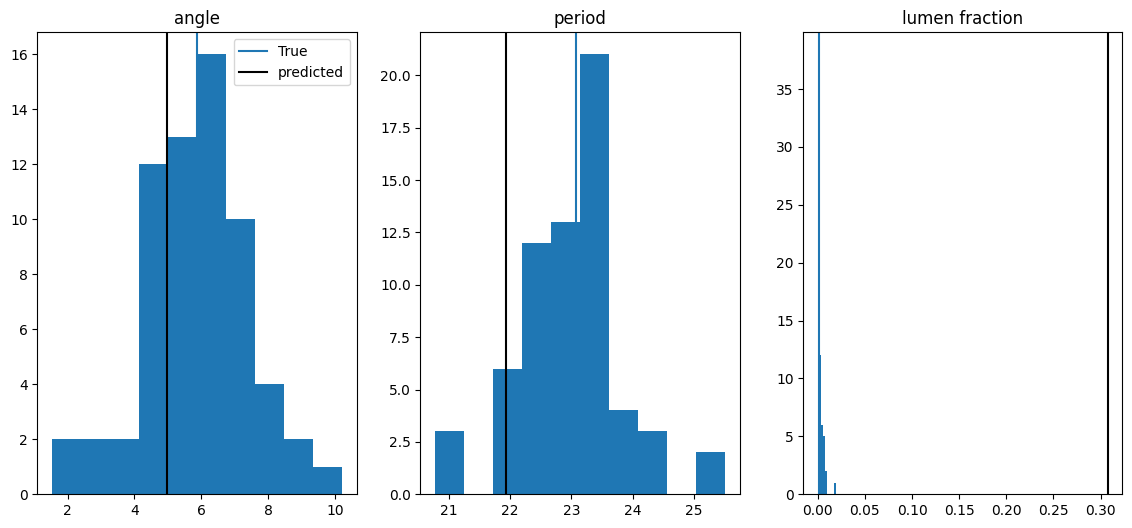

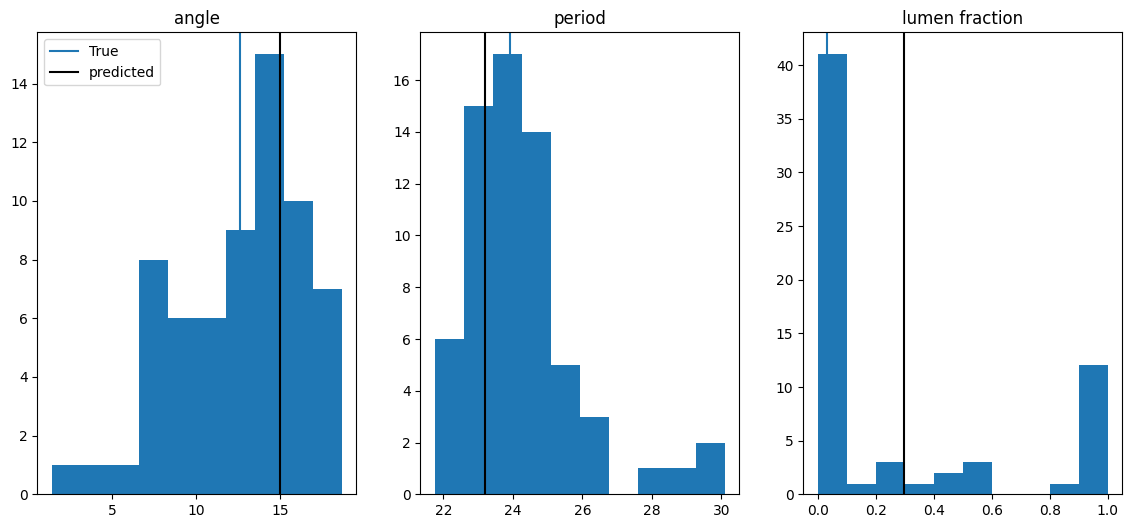

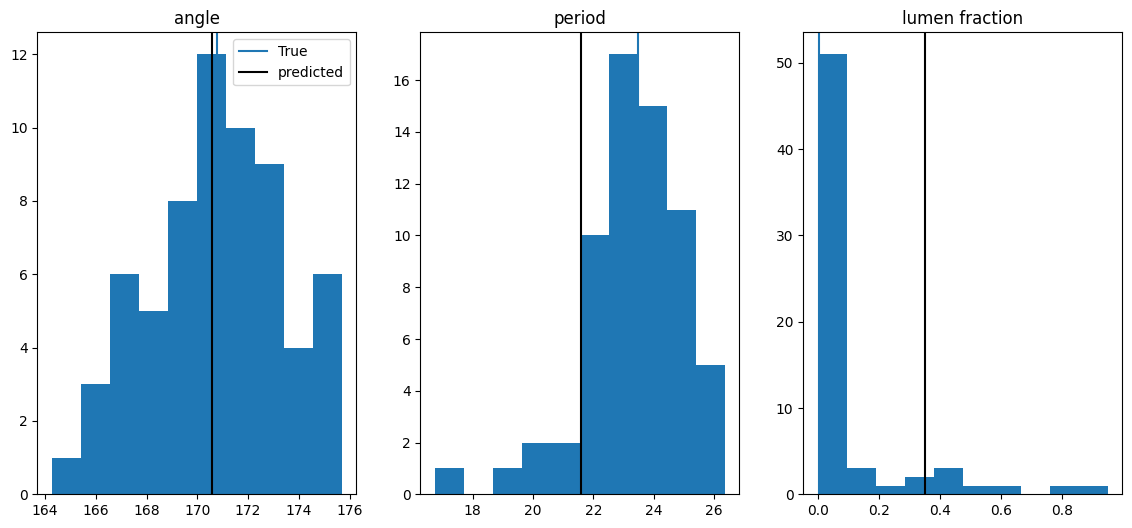

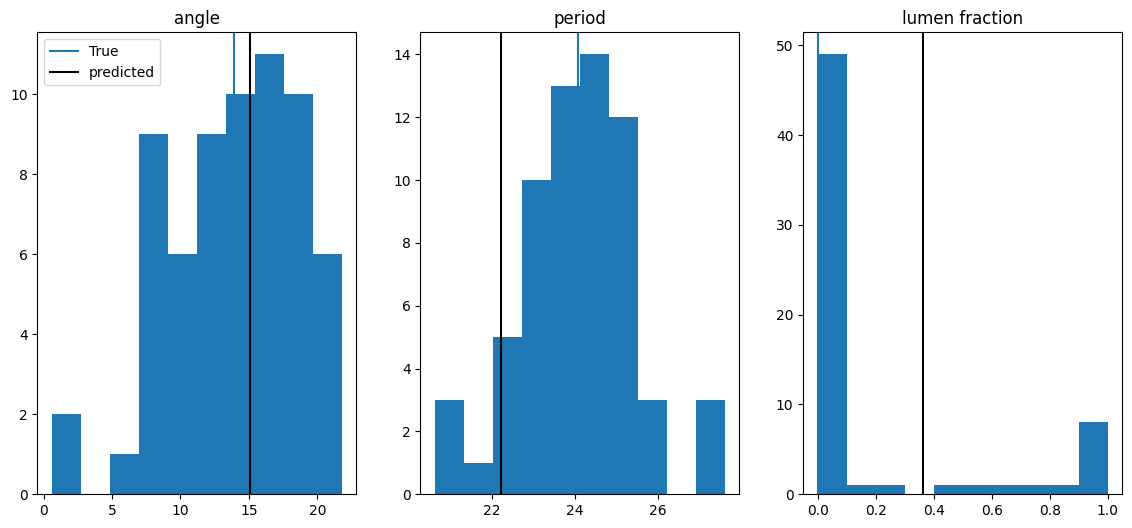

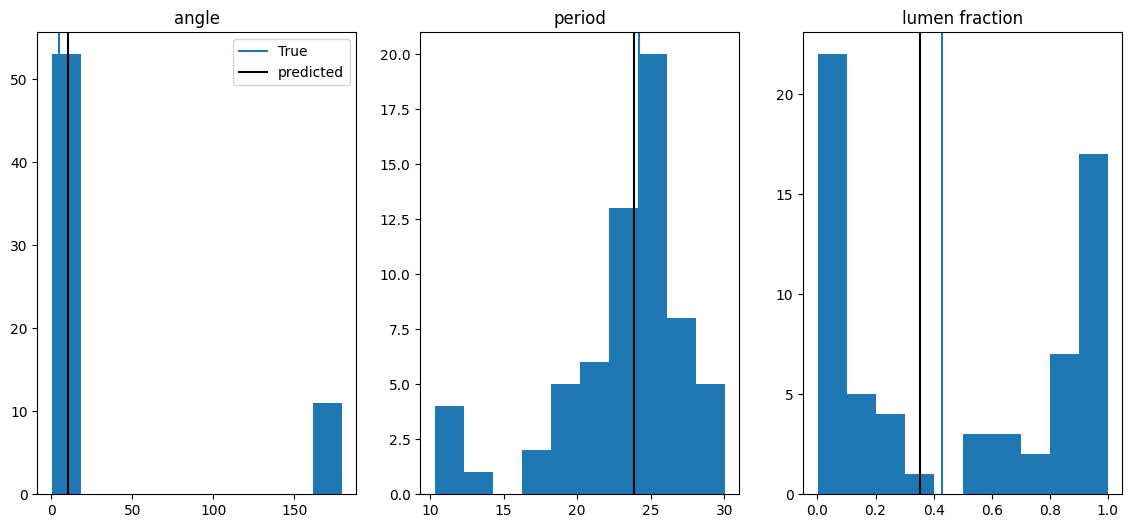

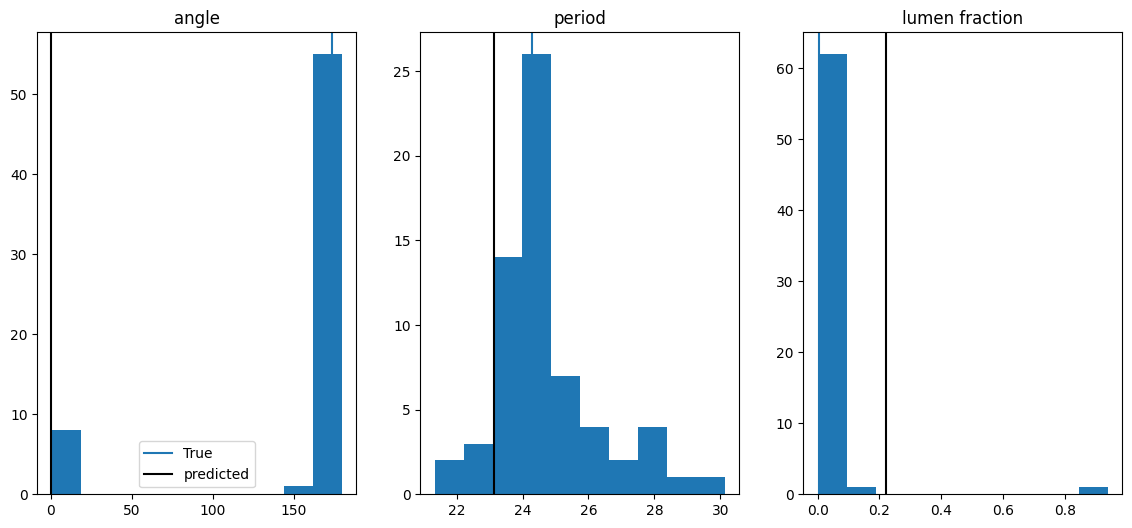

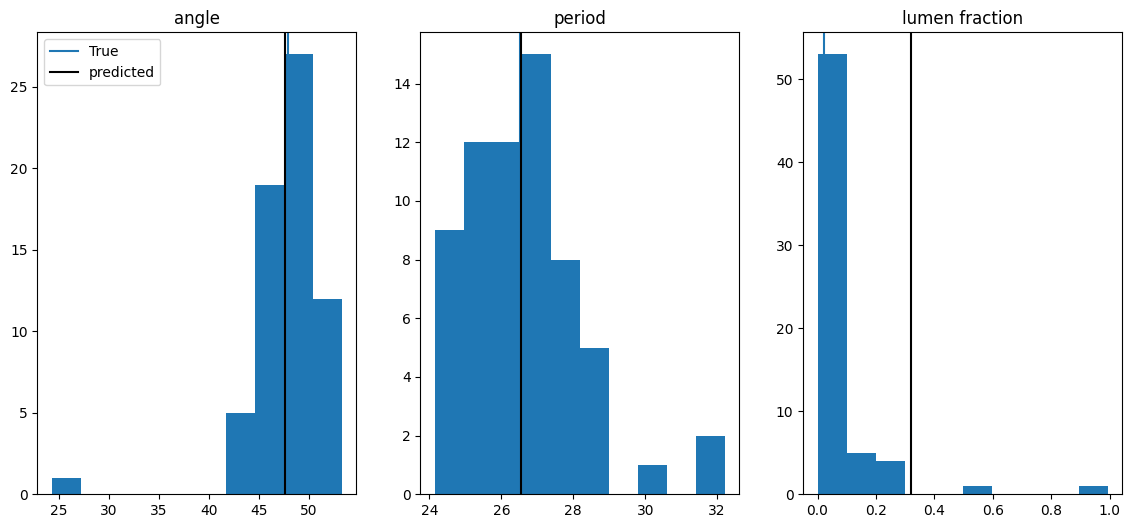

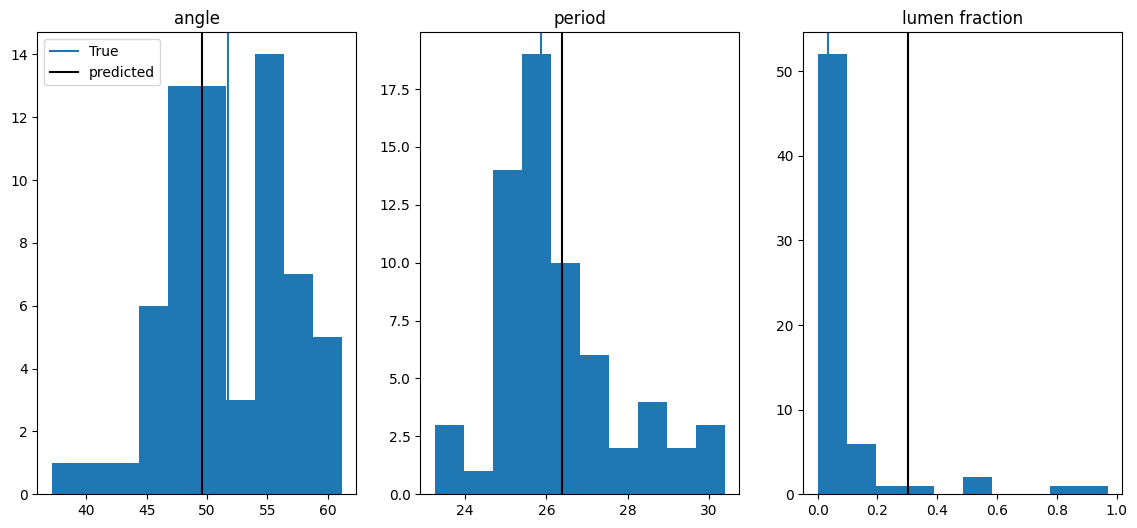

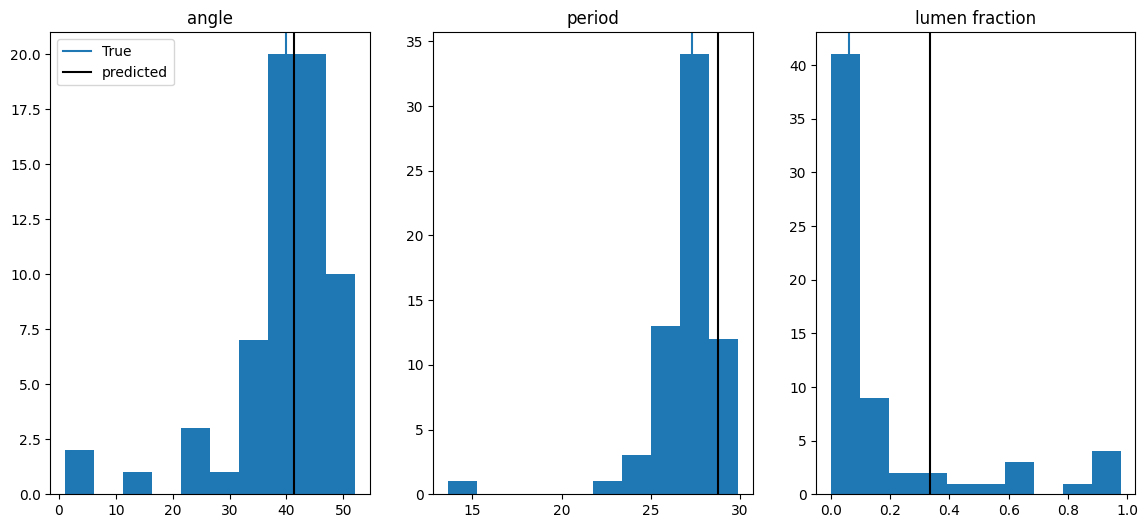

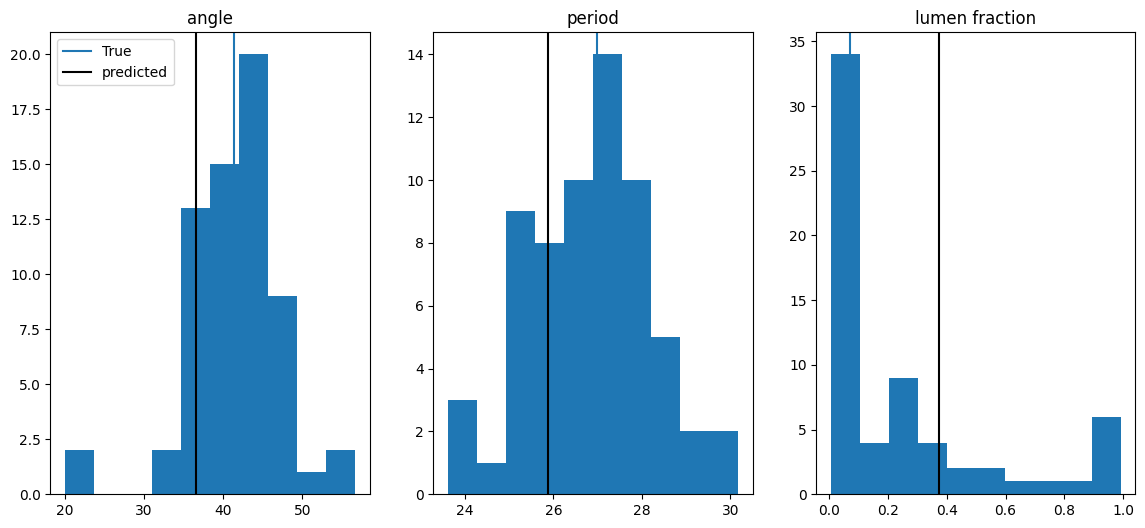

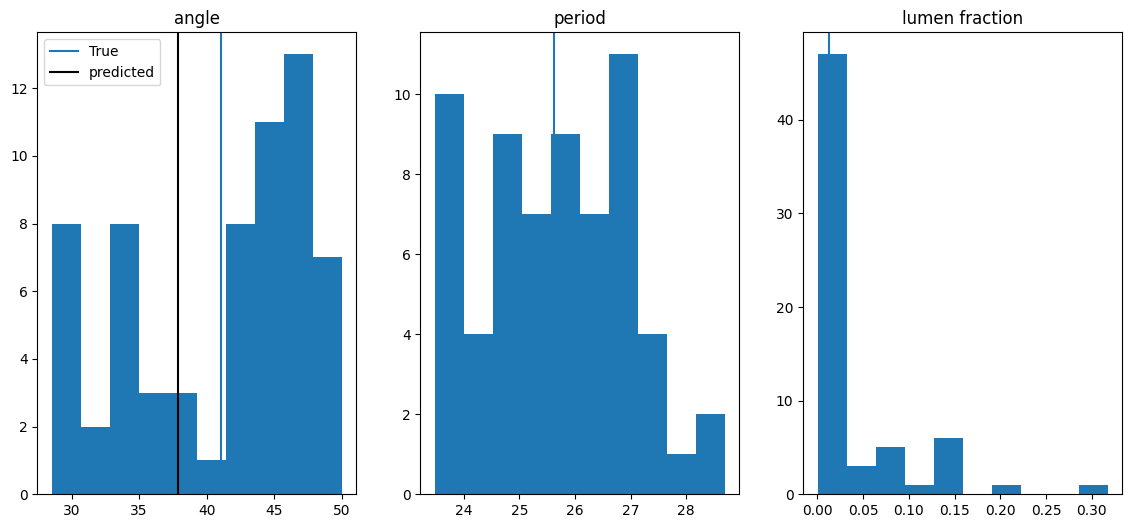

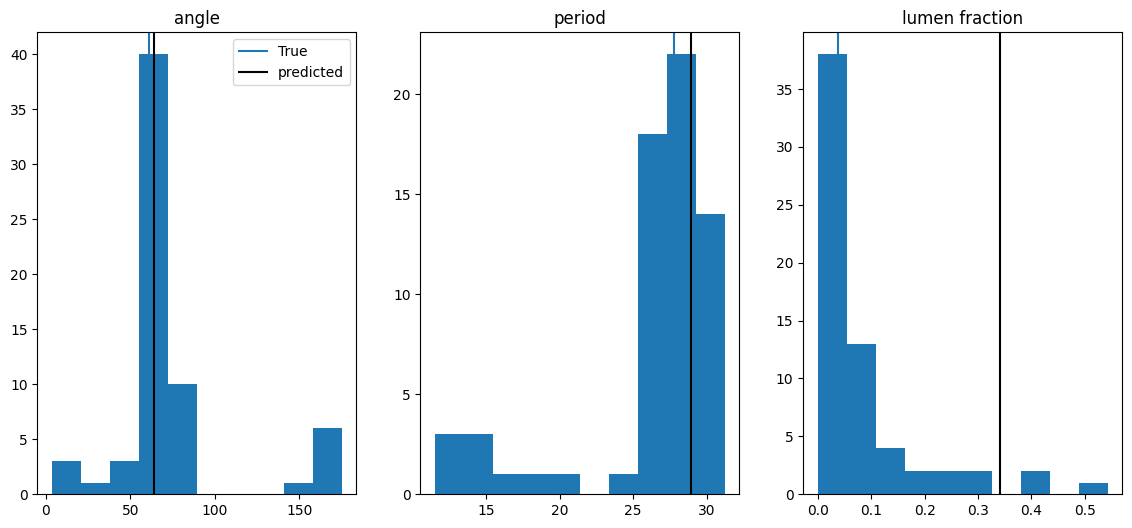

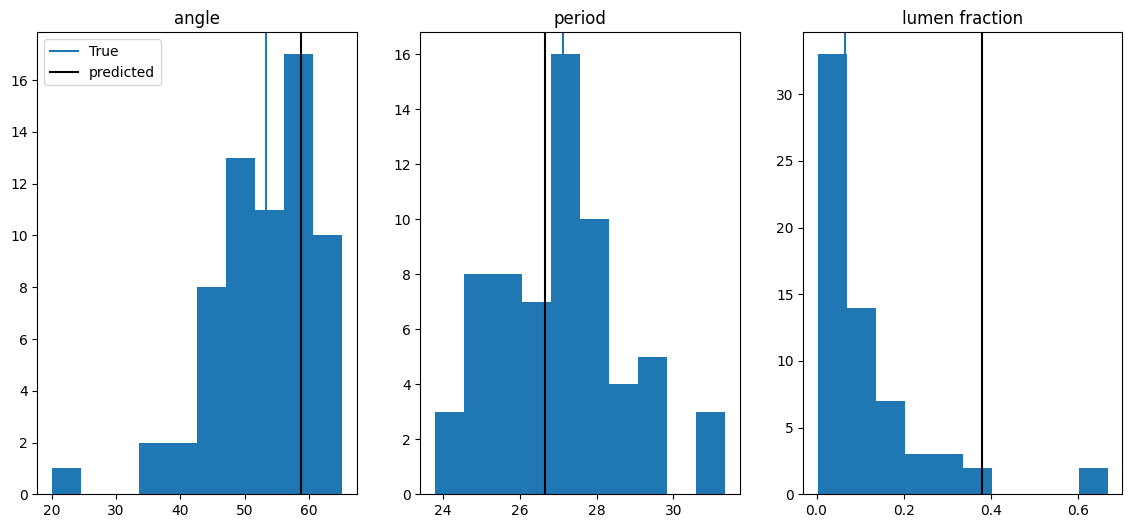

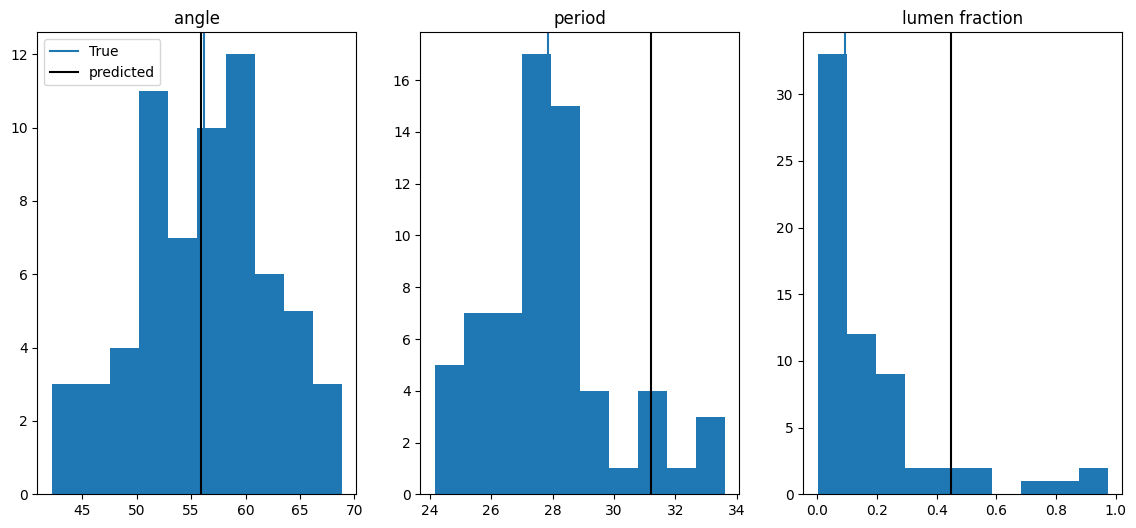

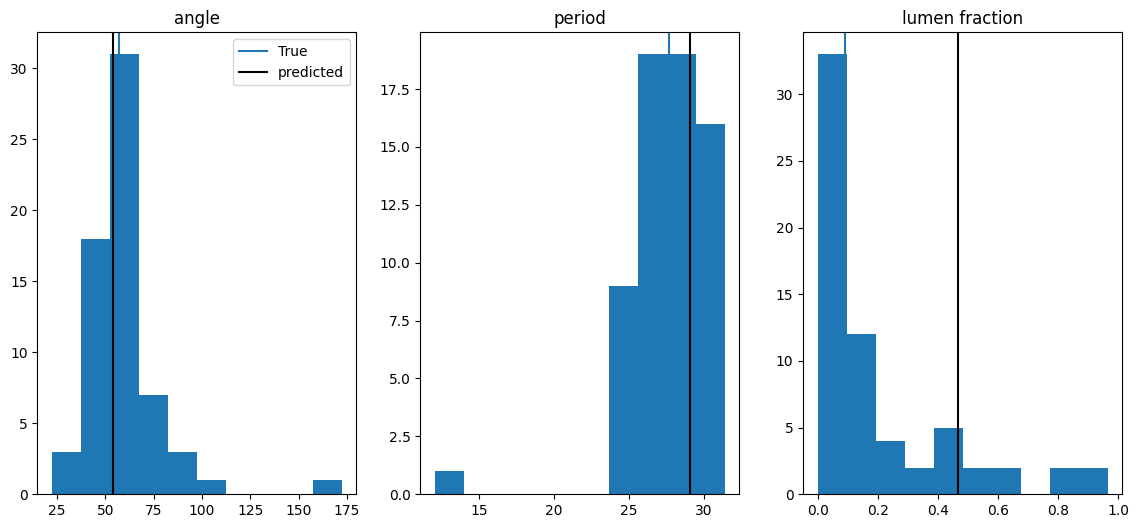

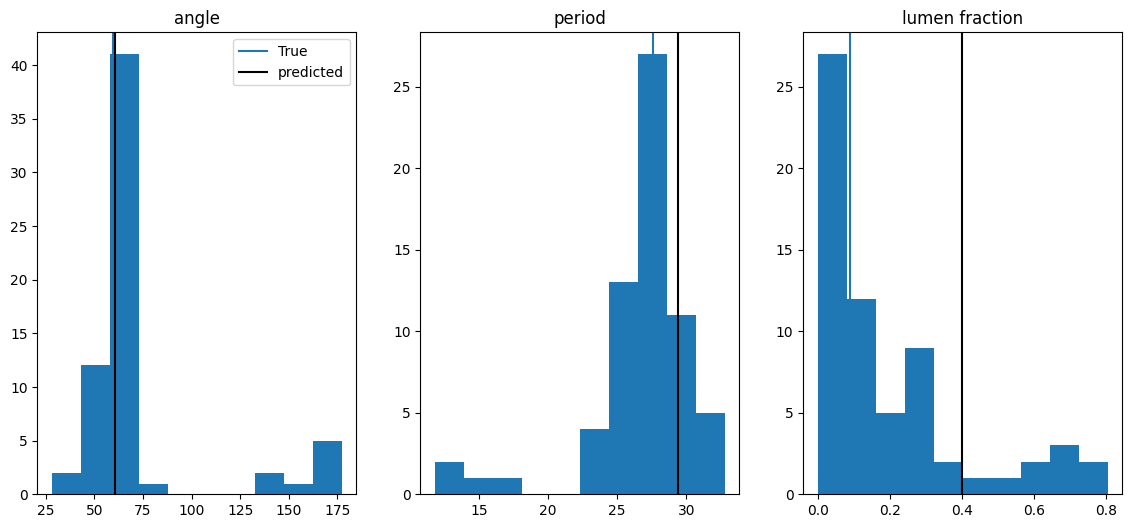

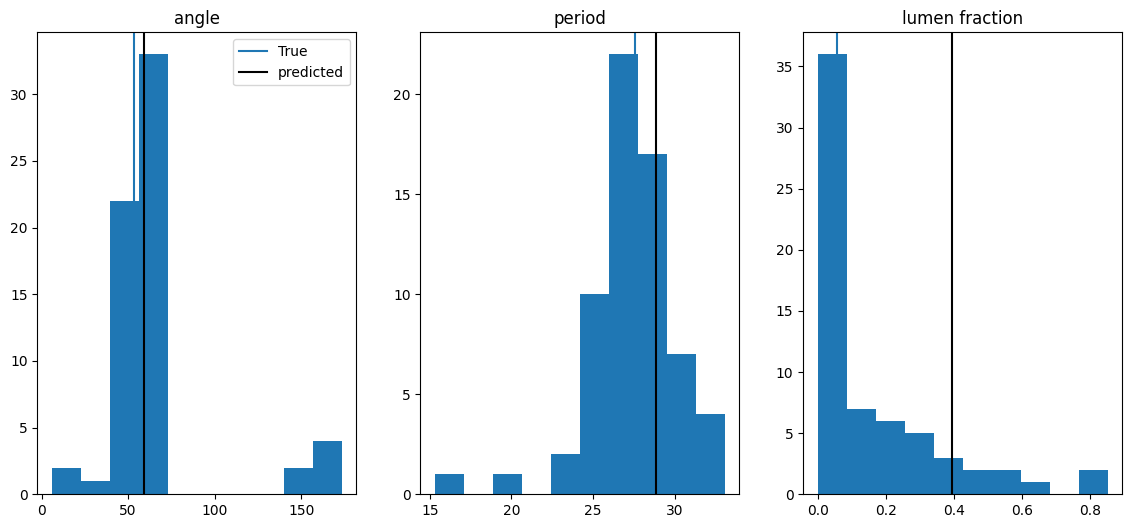

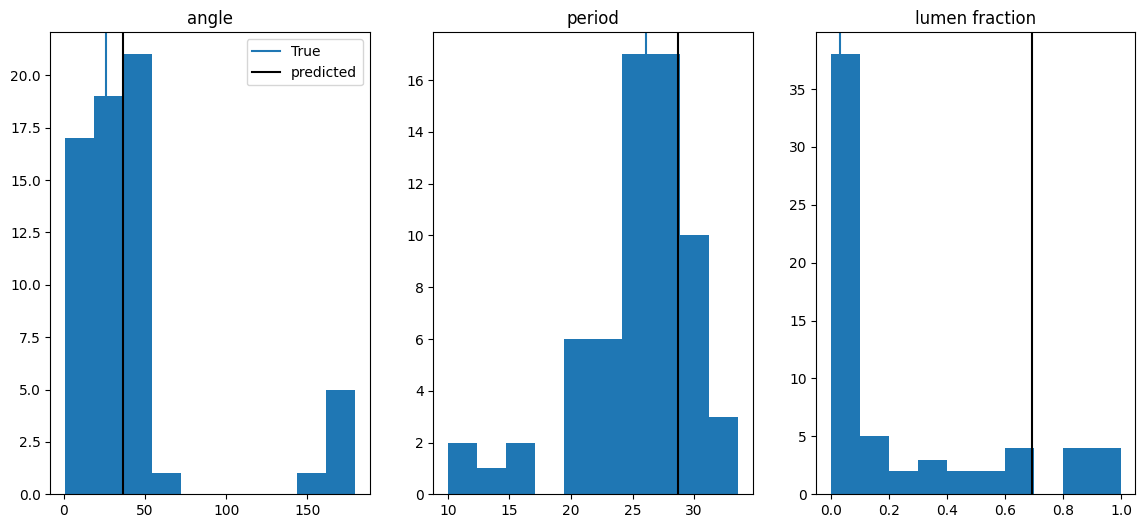

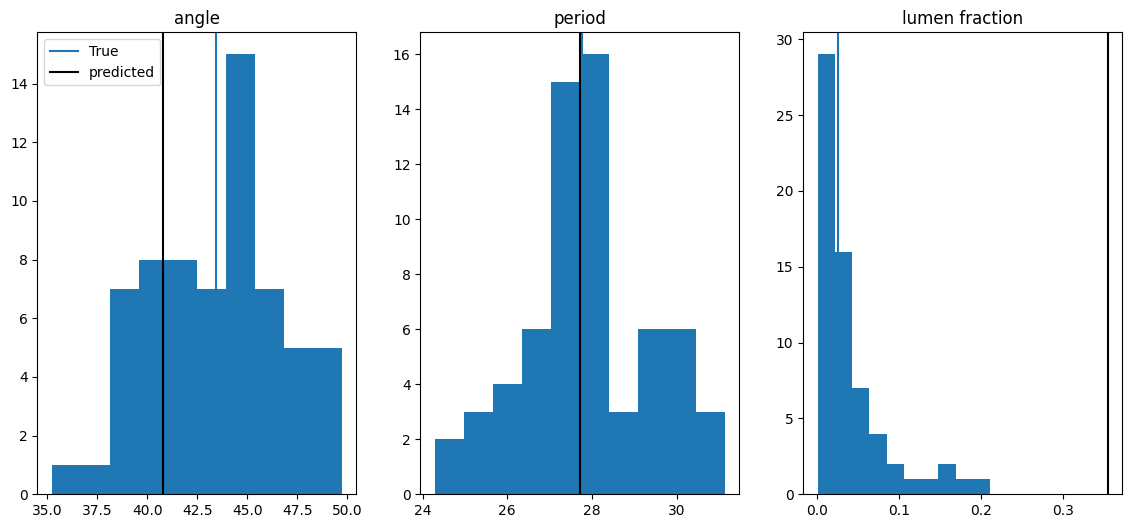

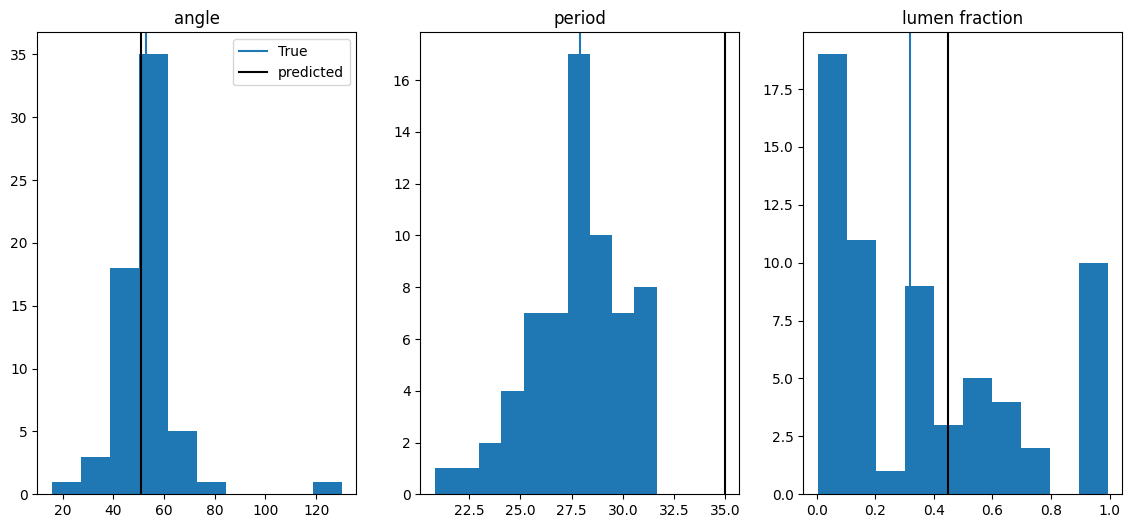

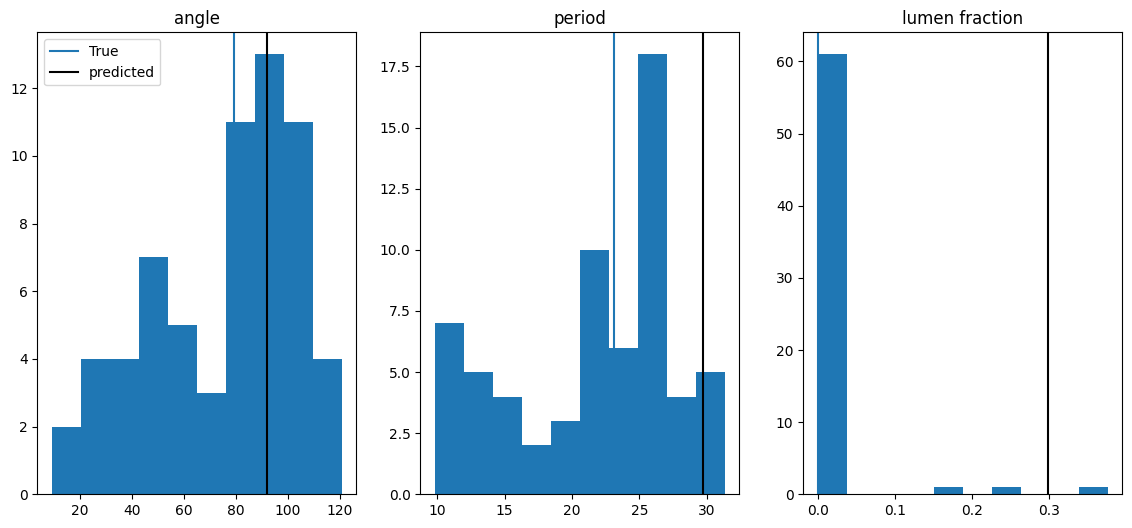

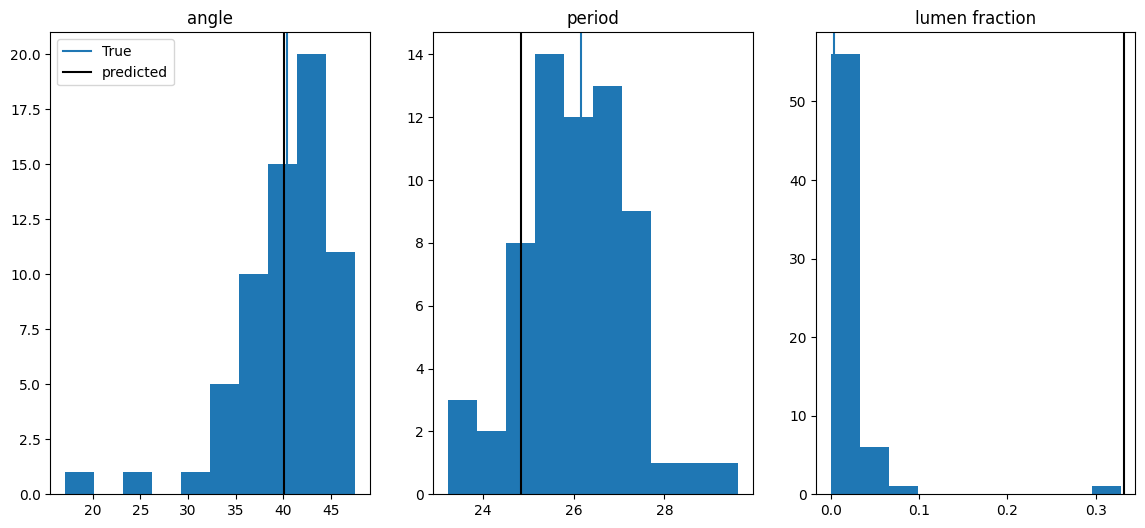

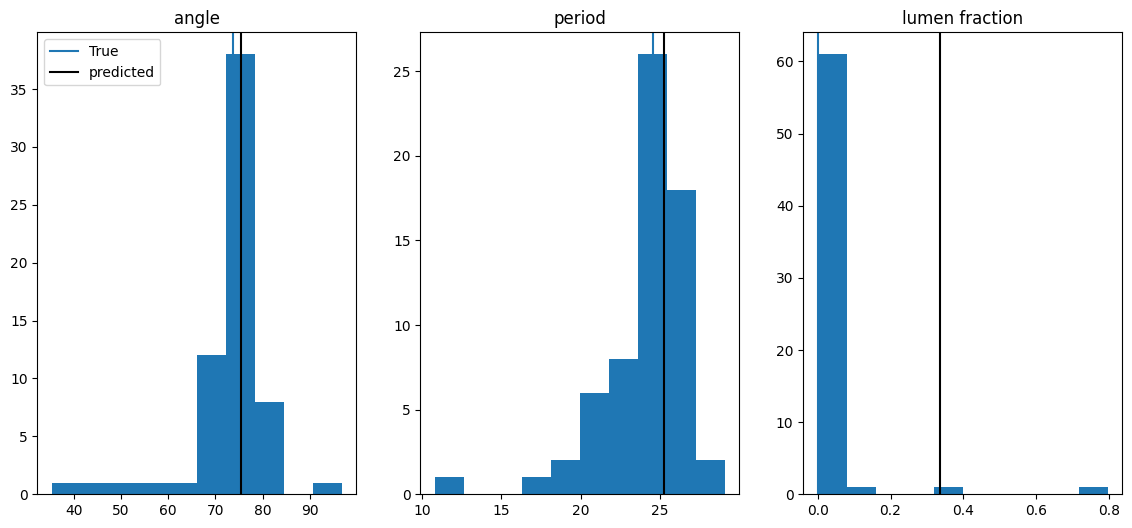

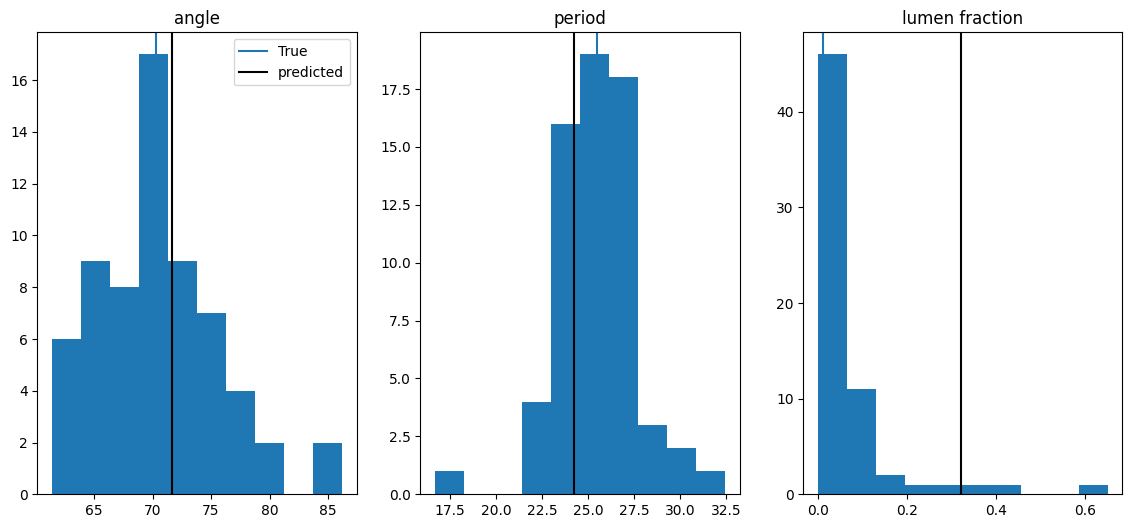

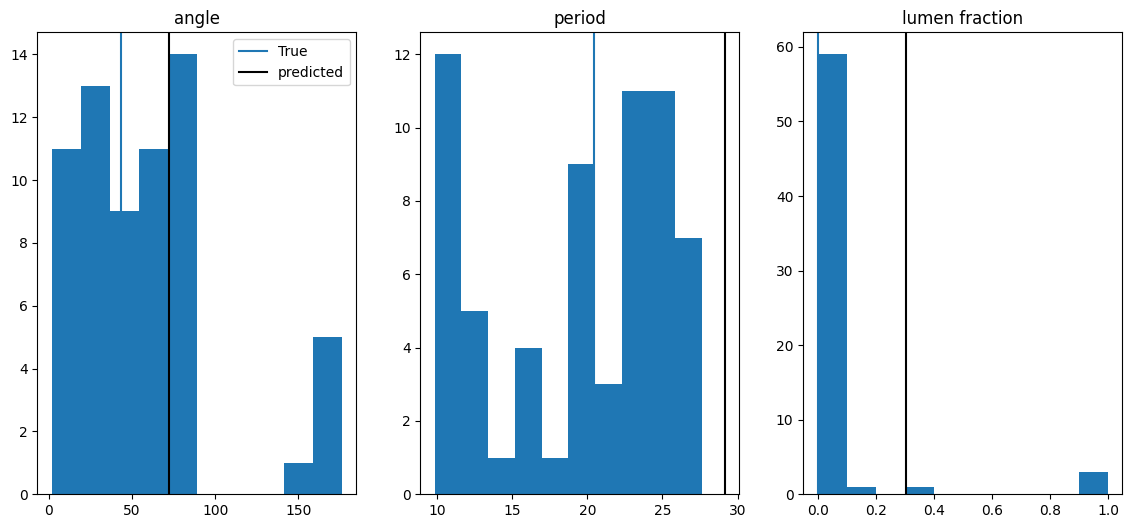

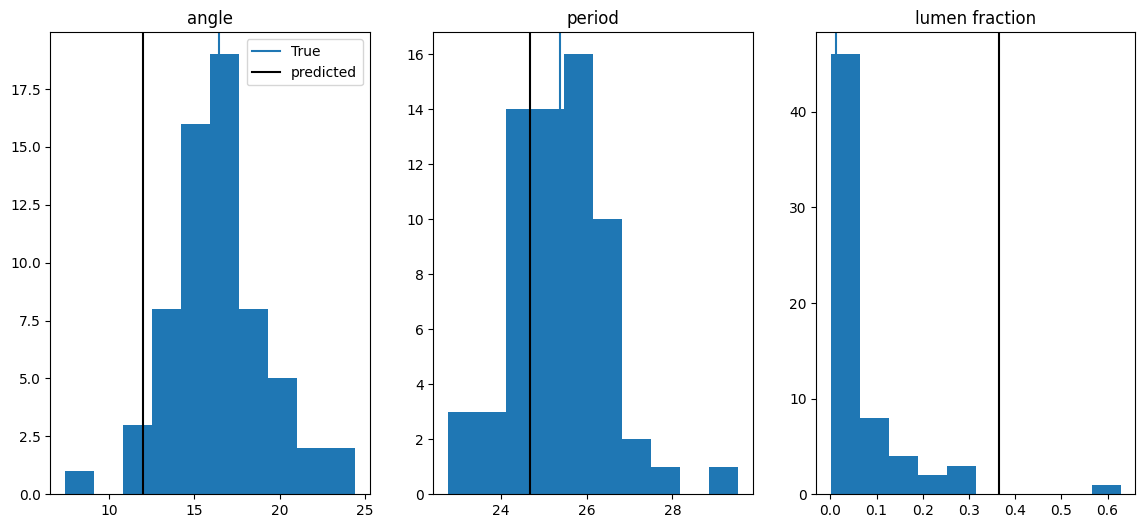

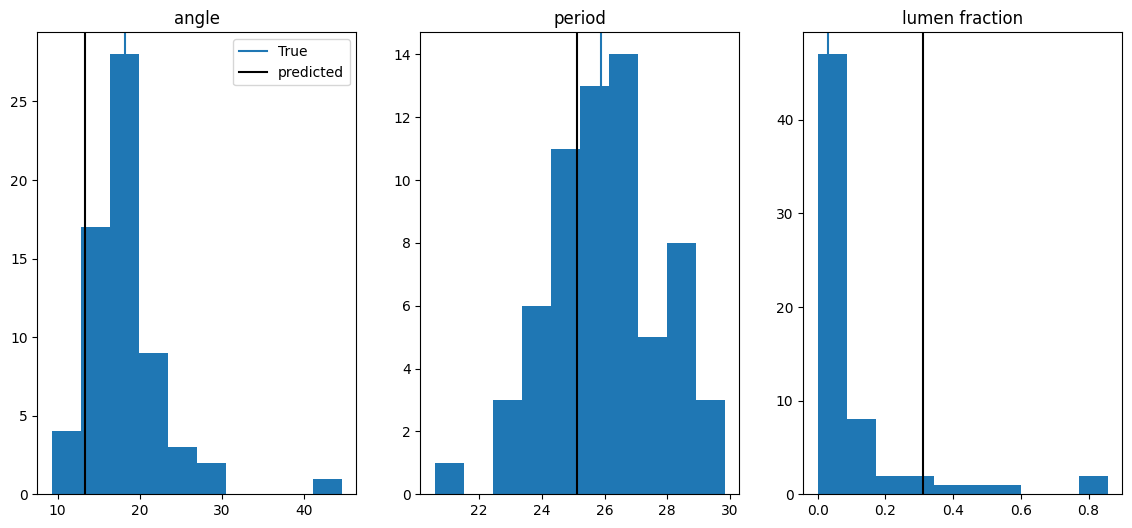

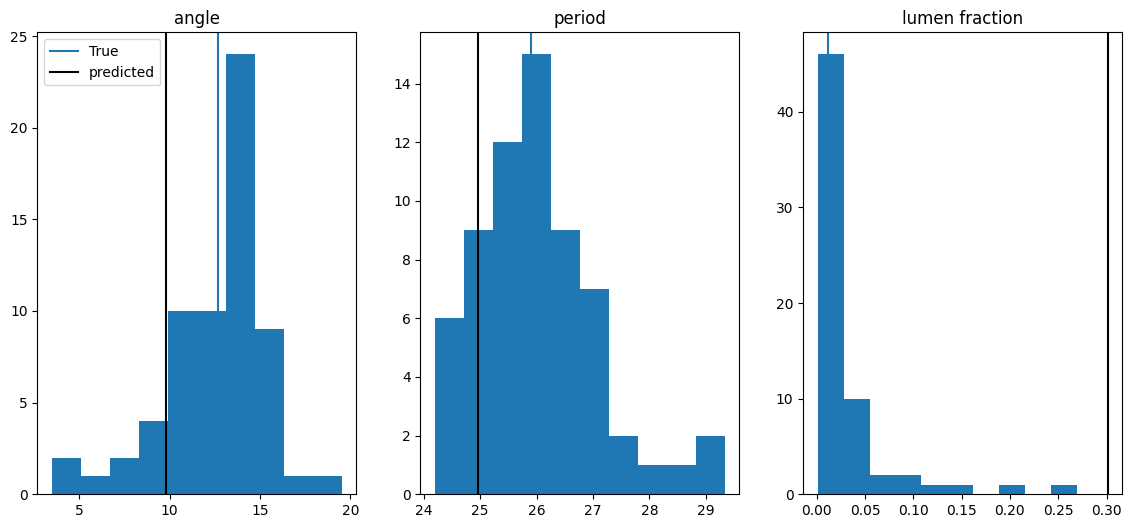

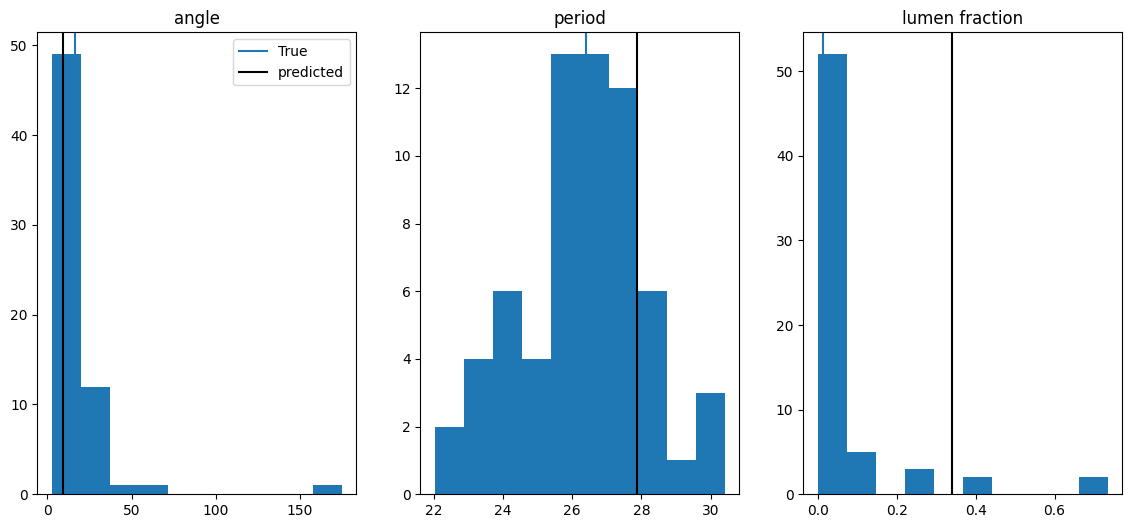

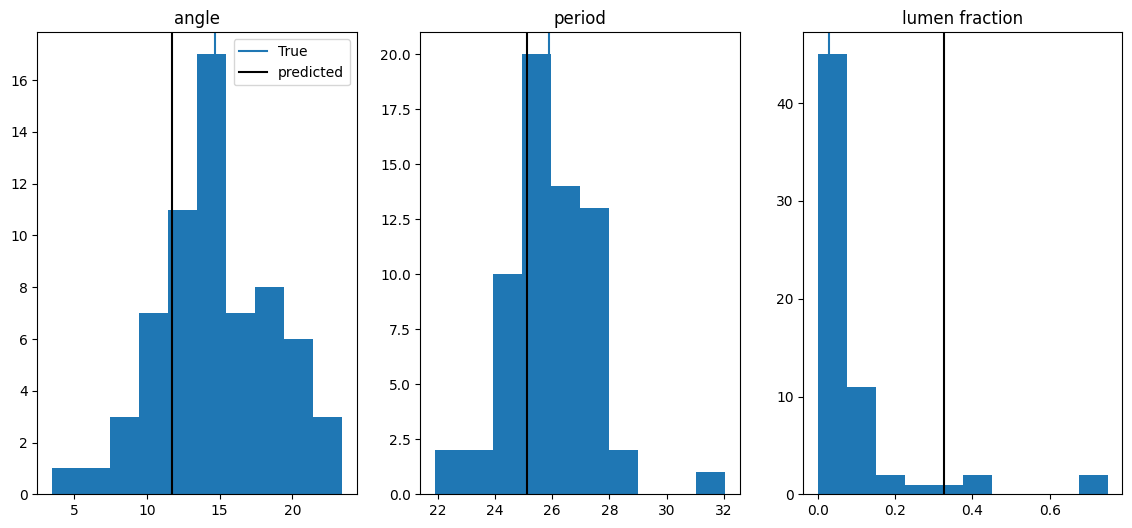

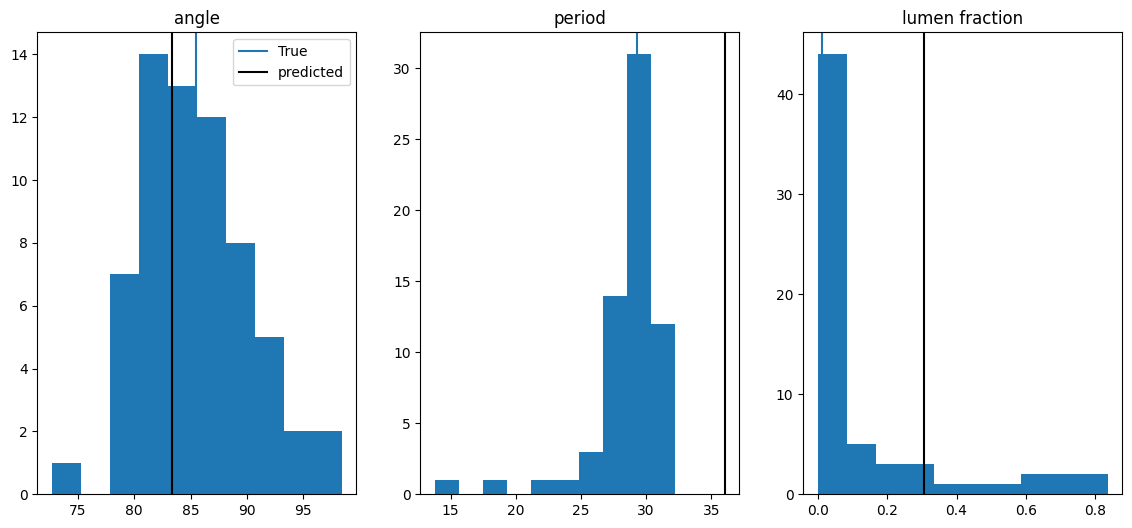

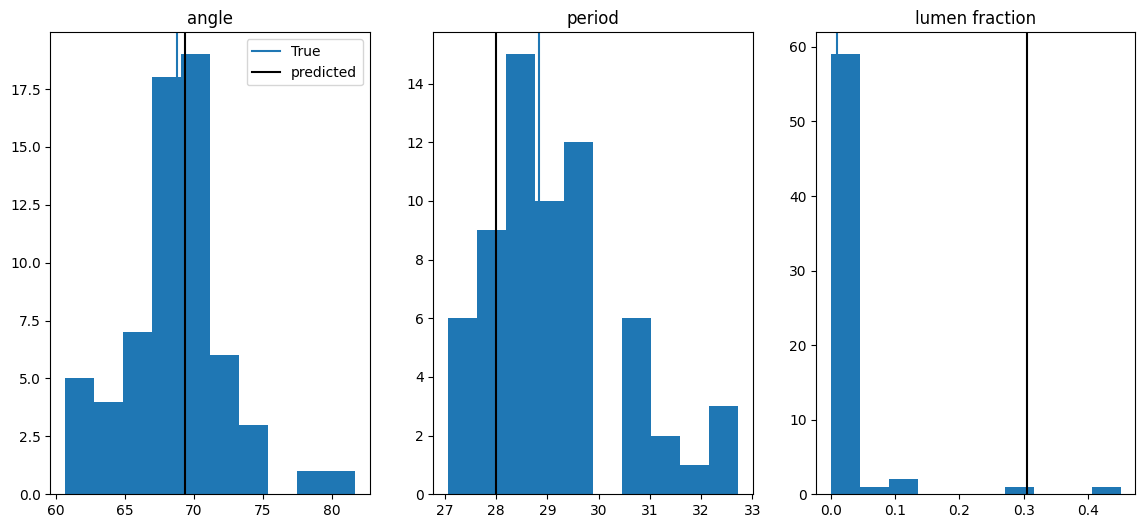

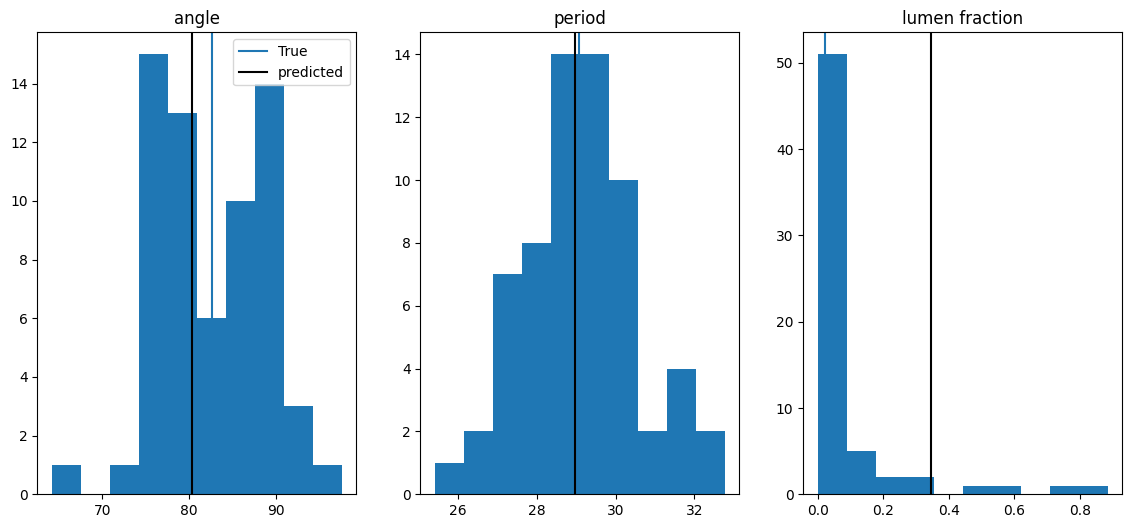

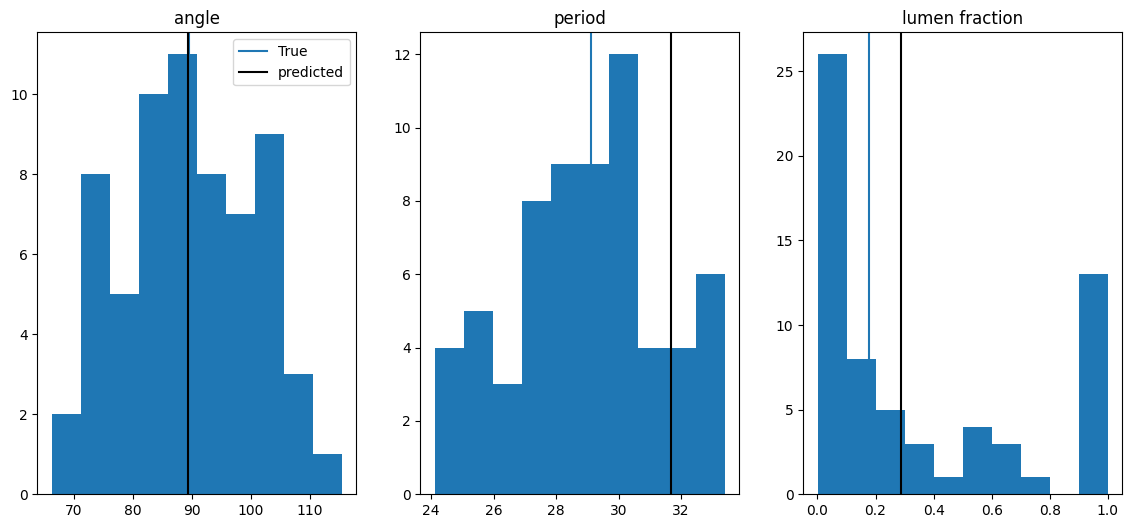

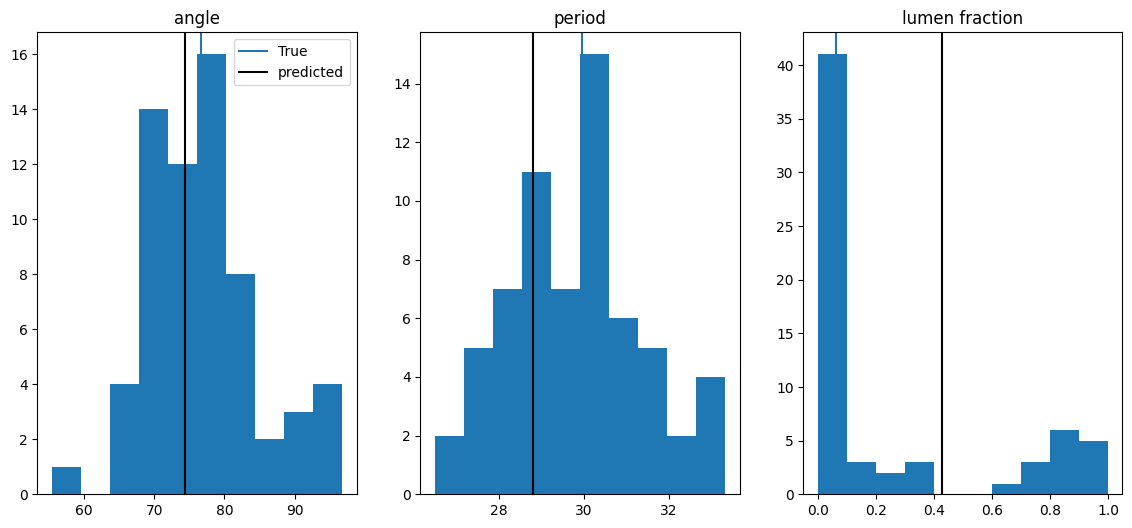

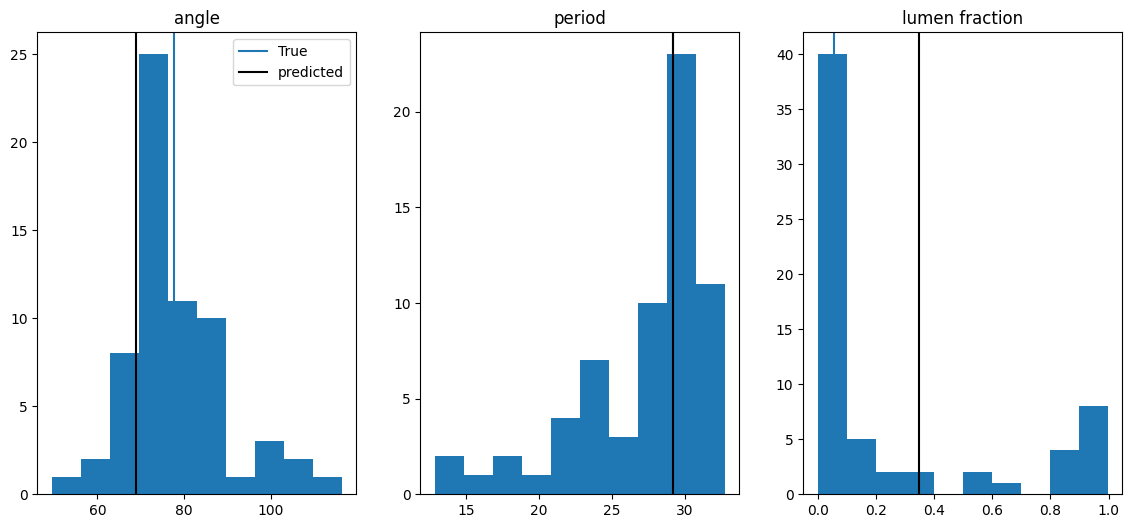

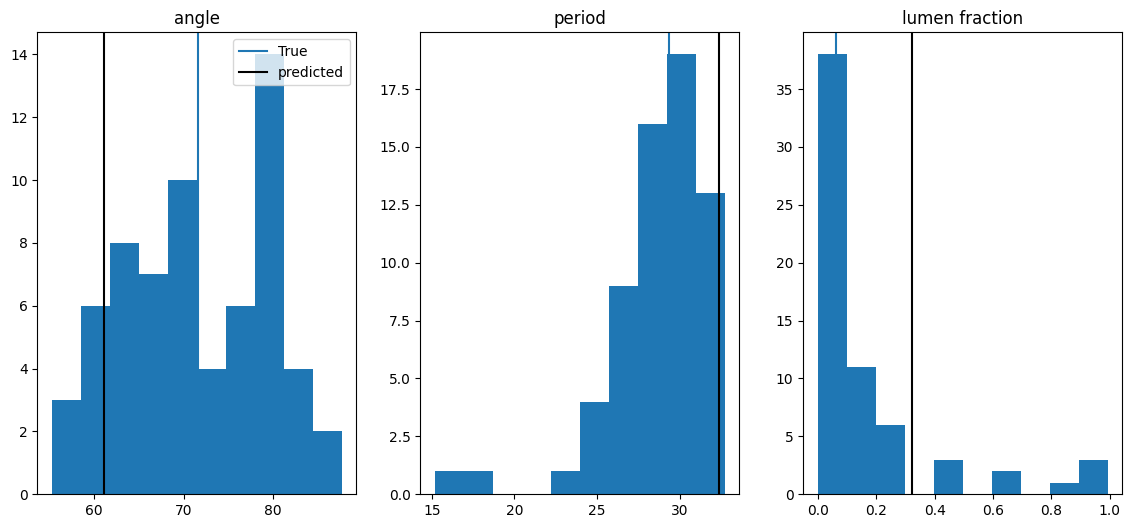

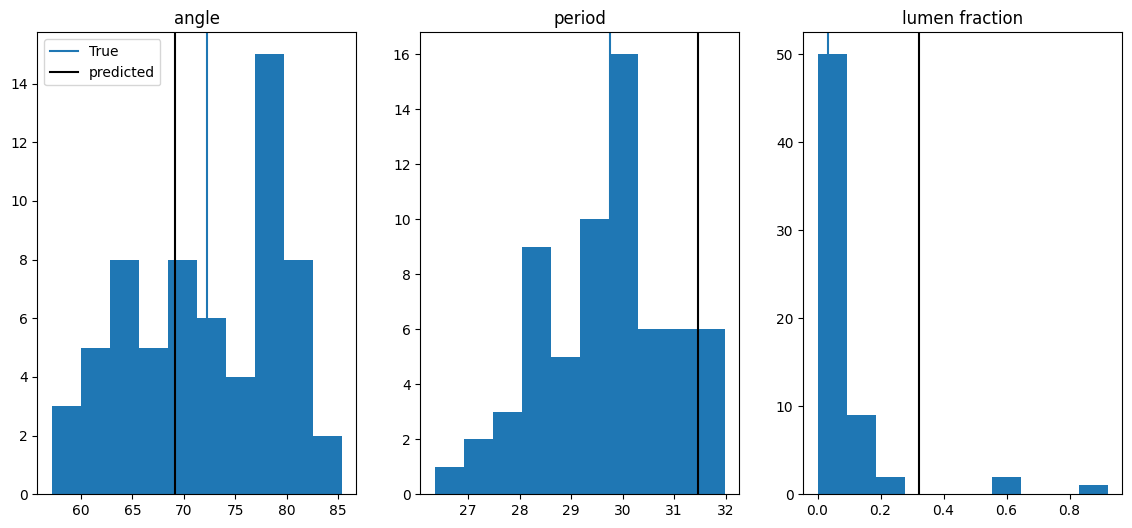

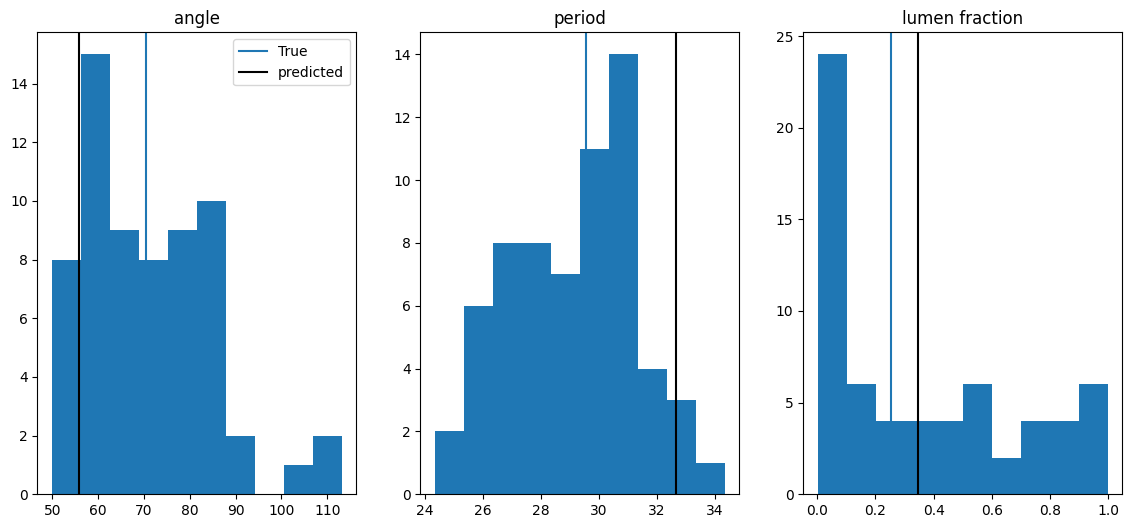

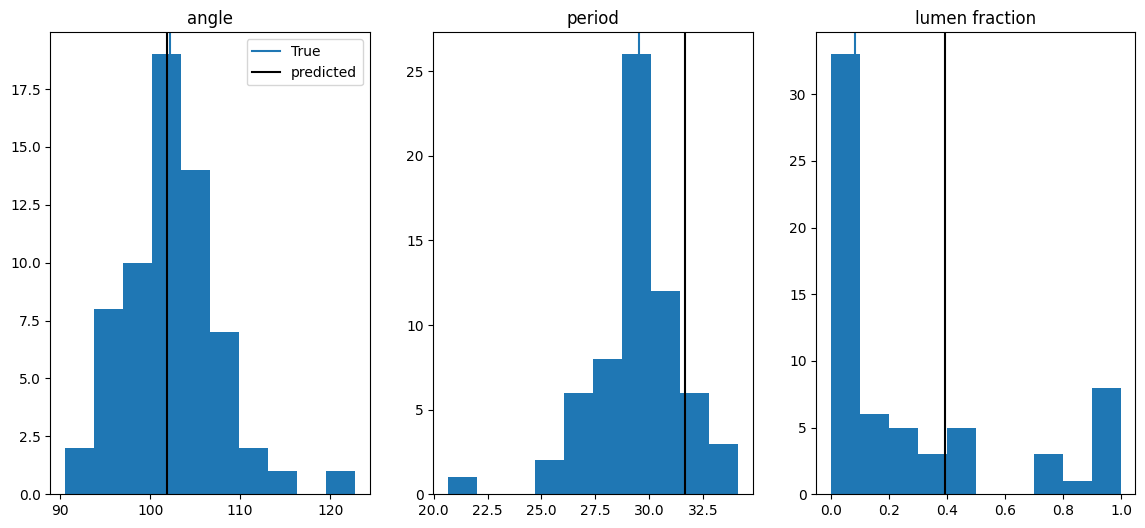

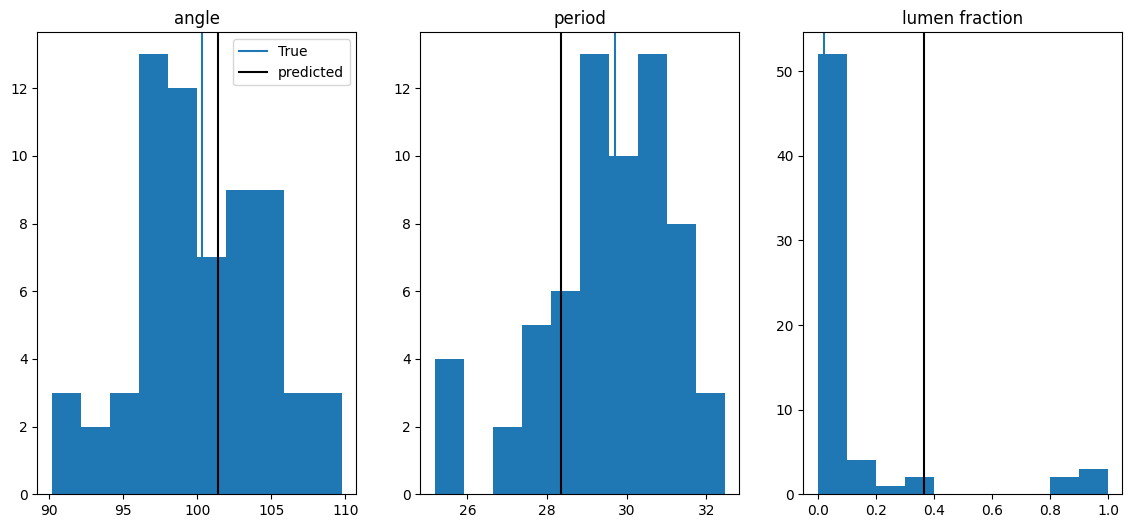

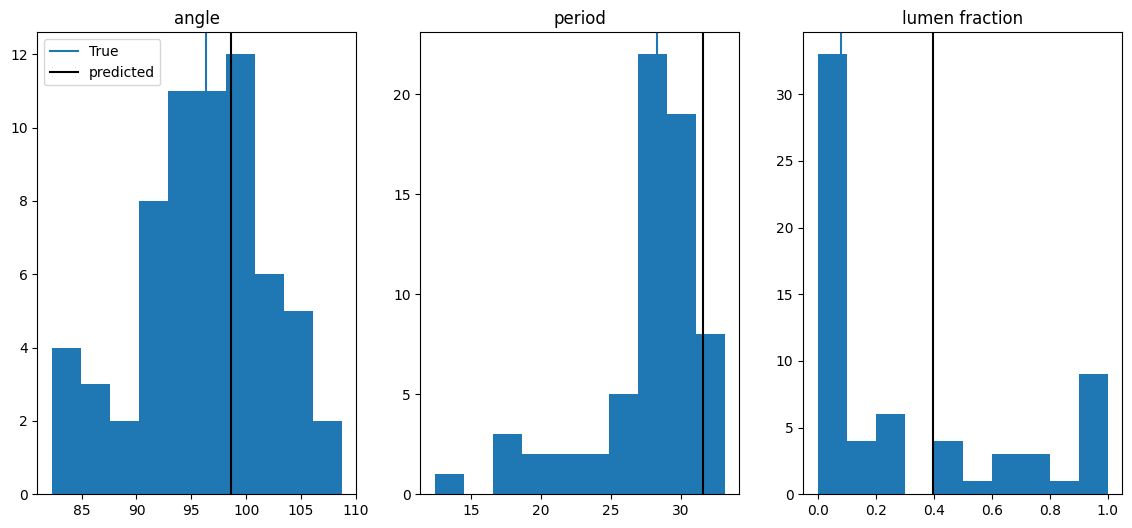

In [30]:
results = []
for i in range(len(annotations)):
    data_row = annotations.iloc[i]
    try:
        result_entry = analyse_image(data_row)
    except:
        print(data_row['object_filename'])
        continue
    entry = {f'predicted_{k}': v for k, v in result_entry['preds'].items()}
    entry.update(data_row.to_dict())
    results.append(entry)
results = pd.DataFrame(results)
results['angle_error'] = angle_difference(results['predicted_angle'], results['angle'])

#### period error

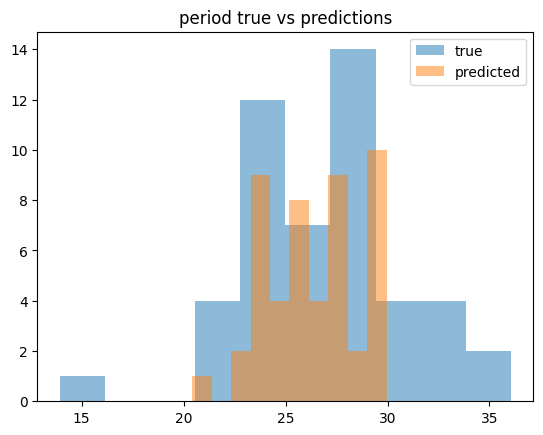

In [31]:
plt.hist(results['period'], alpha=0.5, label='true')
plt.hist(results['predicted_period'], alpha=0.5, label='predicted')
plt.title('period true vs predictions');
plt.legend();

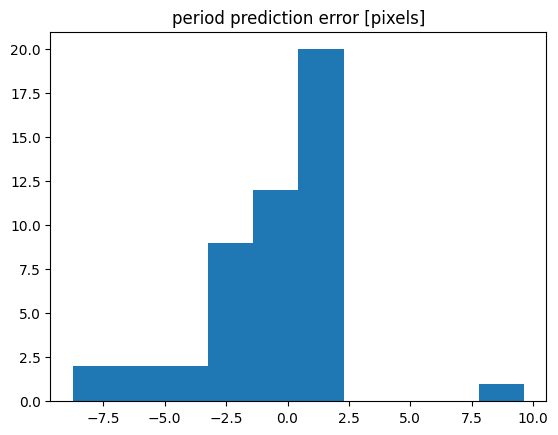

In [35]:
plt.hist(results['predicted_period'] - results['period'])
plt.title('period prediction error [pixels]');


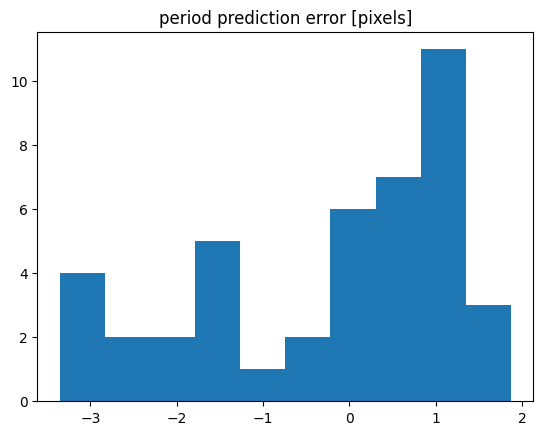

In [36]:
resid = results['predicted_period'] - results['period']
mask = abs(resid) < 5
plt.hist(resid[mask])
plt.title('period prediction error [pixels]');


In [78]:
results.columns

Index(['predicted_angle', 'predicted_period', 'predicted_lumen_fraction',
       'predicted_angle_std', 'predicted_period_std',
       'predicted_lumen_frac_std', 'object_filename', 'image_filename',
       'object_idx', 'angle', 'hight', 'diameter_min', 'diameter_max',
       'diameter_mean', 'layers_lumnen_fraction', 'granum_lumen_fraction',
       'layers_number', 'period', 'readable_code', 'readable', 'angle_error'],
      dtype='object')

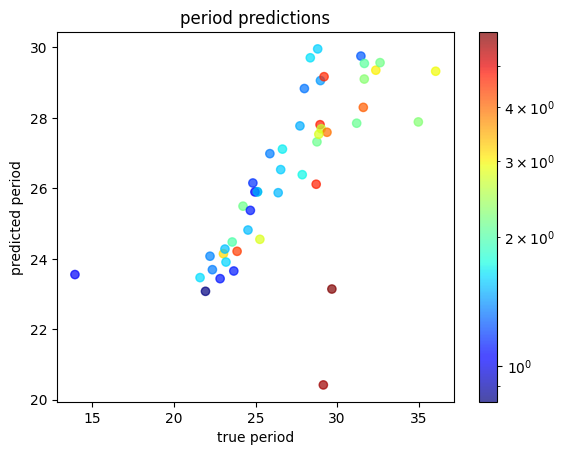

In [79]:
plt.scatter(results['period'], results['predicted_period'], c=results['predicted_period_std'], cmap='jet', alpha=0.7, norm=matplotlib.colors.LogNorm())
plt.xlabel('true period')
plt.ylabel('predicted period')
plt.colorbar()
plt.title('period predictions');


#### angles error

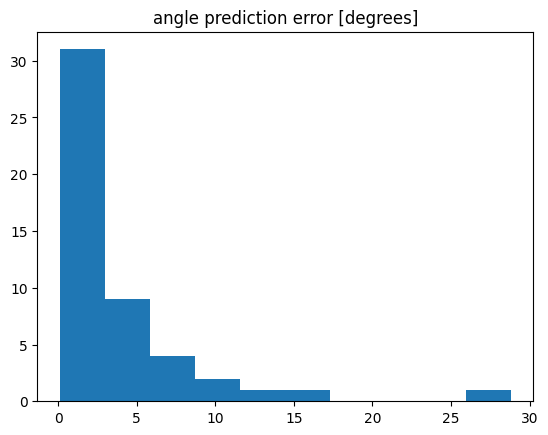

In [37]:
plt.hist(results['angle_error'])
plt.title('angle prediction error [degrees]');

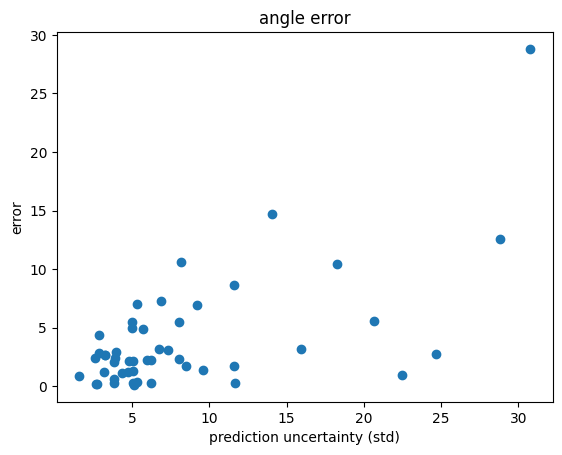

In [81]:
plt.scatter(results['predicted_angle_std'], results['angle_error'])
plt.xlabel('prediction uncertainty (std)')
plt.ylabel('error')
plt.title('angle error');


#### lumen fraction

In [38]:
# results.columns

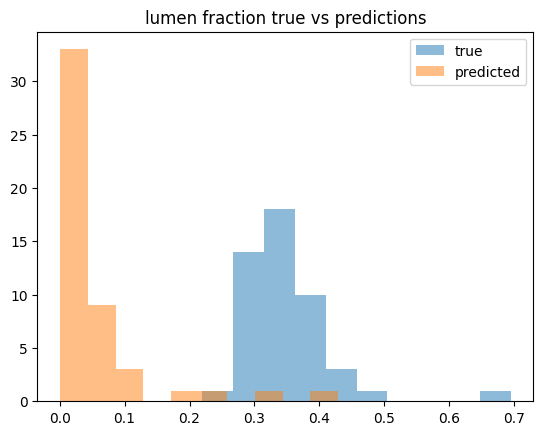

In [39]:
plt.hist(results['granum_lumen_fraction'], alpha=0.5, label='true')
plt.hist(results['predicted_lumen_fraction'], alpha=0.5, label='predicted')
plt.title('lumen fraction true vs predictions');
plt.legend();

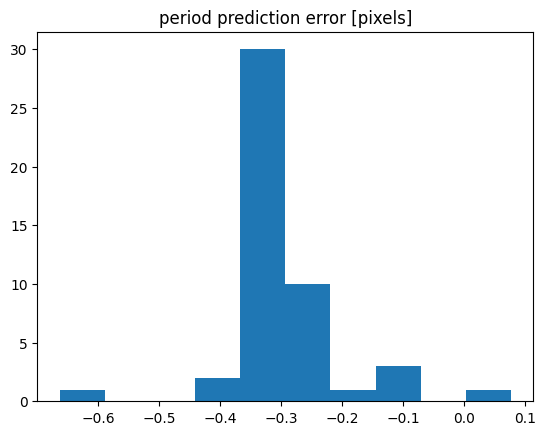

In [40]:
plt.hist(results['predicted_lumen_fraction'] - results['granum_lumen_fraction'])
plt.title('period prediction error [pixels]');


In [83]:
results.columns

Index(['predicted_angle', 'predicted_period', 'predicted_lumen_fraction',
       'predicted_angle_std', 'predicted_period_std',
       'predicted_lumen_frac_std', 'object_filename', 'image_filename',
       'object_idx', 'angle', 'hight', 'diameter_min', 'diameter_max',
       'diameter_mean', 'layers_lumnen_fraction', 'granum_lumen_fraction',
       'layers_number', 'period', 'readable_code', 'readable', 'angle_error'],
      dtype='object')

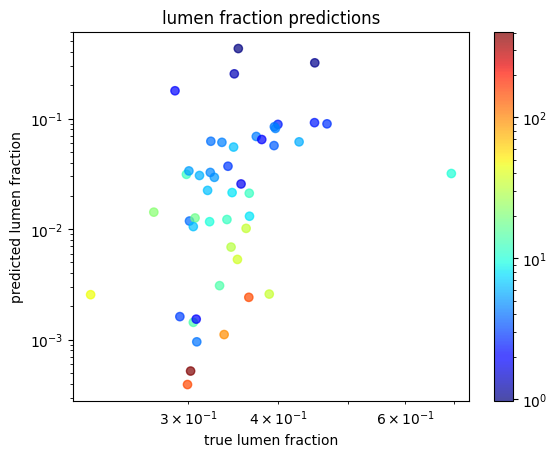

In [88]:
plt.scatter(results['granum_lumen_fraction'], results['predicted_lumen_fraction'], c=results['predicted_lumen_frac_std']/results['predicted_lumen_fraction'], cmap='jet', alpha=0.7, norm=matplotlib.colors.LogNorm())
plt.xlabel('true lumen fraction')
plt.ylabel('predicted lumen fraction')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.title('lumen fraction predictions');


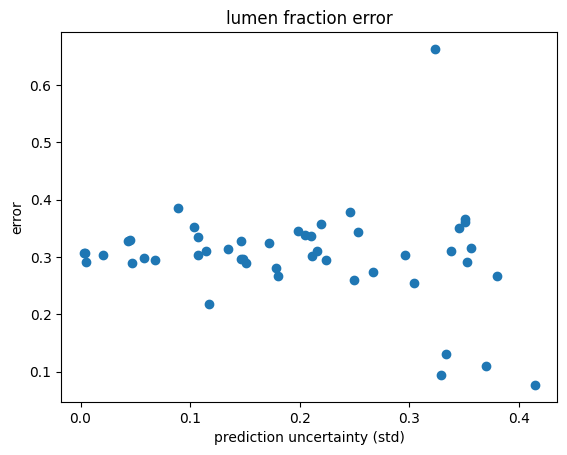

In [91]:
plt.scatter(results['predicted_lumen_frac_std'], abs(results['granum_lumen_fraction']-results['predicted_lumen_fraction']))
plt.xlabel('prediction uncertainty (std)')
plt.ylabel('error')
plt.title('lumen fraction error');


In [41]:
results['image_filename'].unique()

array(['27_hs8 [1].png', '27_hs9 [1].png', '27_k7 [1].png',
       'dgd1_60kx_12 [1].png', 'n6363_araLL_60kx_5 [1].png',
       'n6363_araLL_60kx_6 [1].png'], dtype=object)

## Classic method

In [42]:
annotations.head()

,object_filename,image_filename,object_idx,angle,hight,diameter_min,diameter_max,diameter_mean,layers_lumnen_fraction,granum_lumen_fraction,layers_number,period,readable_code,readable
0,27_hs8 [1]_0.npy,27_hs8 [1].png,0.0,-11.966,264.229,335.518,613.989,464.586466666667,5.498,0.292254,15,22.829386,2.0,True
1,27_hs8 [1]_1.npy,27_hs8 [1].png,1.0,-2.564,155.248,412.435,644.119,542.455555555556,10.149,0.344107,9,22.355712,2.0,True
2,27_hs8 [1]_2.npy,27_hs8 [1].png,2.0,-24.476,113.604,555.331,630.601,592.051666666667,8.627,0.361035,6,24.538464,2.0,True
3,27_hs8 [1]_3.npy,27_hs8 [1].png,3.0,-25.731,71.092,481.973,488.875,485.256,5.624,0.388679,4,23.033808,2.0,True
4,27_hs8 [1]_4.npy,27_hs8 [1].png,4.0,-25.663,219.148,358.438,613.339,457.120083333333,7.247,0.308458,12,23.667984,2.0,True


In [43]:
%load_ext autoreload
%autoreload 2

In [44]:
from skimage import io
import os, sys
sys.path.append(os.path.abspath('src'))

In [45]:
from classic import calculate_white_fraction, get_period_with_confidence, get_rotation_with_confidence, calculate_autocorrelation, measure_object

In [46]:
objects_dir = Path('../01_data/cropped/A/objects')

In [47]:
results_classic = []
for i in range(len(annotations)):
    data_row = annotations.iloc[i]
    img_filename = objects_dir / data_row['object_filename'].replace('.npy', '.png')
    if not img_filename.exists():
        print(data_row['object_filename'])
        continue
    img_raw = io.imread(img_filename)
    img = img_raw[:,:,0]

    granum_mask = (img_raw != (0,0,255)).any(axis=2)
    measurements = measure_object(img, granum_mask)
    result_entry = {
        'angle': measurements['direction'],
        'period': measurements['period'],
        'lumen_fraction': measurements['white_strip_width'] / measurements['period'],
        'angle_quality': measurements['direction_confidence'],
        'period_quality': measurements['period_quality'],
    }
    entry = {f'predicted_{k}': v for k, v in result_entry.items()}
    entry.update(data_row.to_dict())
    
  
    results_classic.append(entry)
results_classic = pd.DataFrame(results_classic)
results_classic['angle_error'] = angle_difference(results_classic['predicted_angle'], results_classic['angle'])

38_k10[1]_0.npy
38_k10[1]_1.npy
38_k10[1]_2.npy
38_k10[1]_3.npy
38_k10[1]_4.npy
38_k10[1]_5.npy
38_k10[1]_6.npy
38_k10[1]_7.npy
38_k10[1]_8.npy
38_k10[1]_12.npy
38_k10[1]_13.npy
38_k10[1]_15.npy
38_k10[1]_16.npy
38_k42[1]_0.npy
38_k42[1]_1.npy
38_k42[1]_2.npy
38_k42[1]_3.npy
38_k42[1]_4.npy
38_k42[1]_5.npy
38_k42[1]_6.npy
38_k42[1]_7.npy
38_k42[1]_8.npy
38_k42[1]_9.npy
38_k42[1]_11.npy
38_k42[1]_12.npy
38_k42[1]_13.npy
38_k42[1]_14.npy
38_k42[1]_15.npy
38_k42[1]_16.npy
38_k42[1]_17.npy
38_k42[1]_18.npy
38_k42[1]_19.npy
38_k42[1]_20.npy
38_k42[1]_21.npy
38_k42[1]_22.npy


In [48]:
results_classic.head()

,predicted_angle,predicted_period,predicted_lumen_fraction,predicted_angle_quality,predicted_period_quality,object_filename,image_filename,object_idx,angle,hight,diameter_min,diameter_max,diameter_mean,layers_lumnen_fraction,granum_lumen_fraction,layers_number,period,readable_code,readable,angle_error
0,168,22.0,0.353846,0.506308,1.000000,27_hs8 [1]_0.npy,27_hs8 [1].png,0.0,-11.966,264.229,335.518,613.989,464.586466666667,5.498,0.292254,15,22.829386,2.0,True,0.034
1,1,25.0,0.456522,0.582511,0.931706,27_hs8 [1]_1.npy,27_hs8 [1].png,1.0,-2.564,155.248,412.435,644.119,542.455555555556,10.149,0.344107,9,22.355712,2.0,True,3.564
2,157,22.5,0.434783,0.525184,0.934219,27_hs8 [1]_2.npy,27_hs8 [1].png,2.0,-24.476,113.604,555.331,630.601,592.051666666667,8.627,0.361035,6,24.538464,2.0,True,1.476
3,157,18.0,0.350000,0.482247,0.693177,27_hs8 [1]_3.npy,27_hs8 [1].png,3.0,-25.731,71.092,481.973,488.875,485.256,5.624,0.388679,4,23.033808,2.0,True,2.731
4,153,23.0,0.348485,0.518987,0.958371,27_hs8 [1]_4.npy,27_hs8 [1].png,4.0,-25.663,219.148,358.438,613.339,457.120083333333,7.247,0.308458,12,23.667984,2.0,True,1.337


#### period

In [66]:
import matplotlib

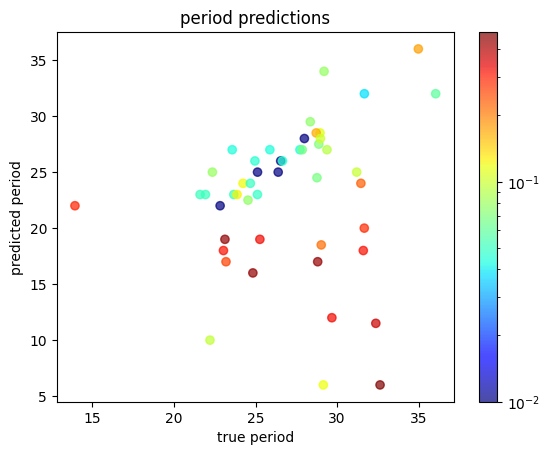

In [67]:
plt.scatter(results_classic['period'], results_classic['predicted_period'], c=1e-2 + 1-results_classic['predicted_period_quality'], cmap='jet', alpha=0.7, norm=matplotlib.colors.LogNorm())
plt.xlabel('true period')
plt.ylabel('predicted period')
plt.colorbar()
plt.title('period predictions');


### angle

In [68]:
results_classic.columns

Index(['predicted_angle', 'predicted_period', 'predicted_lumen_fraction',
       'predicted_angle_quality', 'predicted_period_quality',
       'object_filename', 'image_filename', 'object_idx', 'angle', 'hight',
       'diameter_min', 'diameter_max', 'diameter_mean',
       'layers_lumnen_fraction', 'granum_lumen_fraction', 'layers_number',
       'period', 'readable_code', 'readable', 'angle_error'],
      dtype='object')

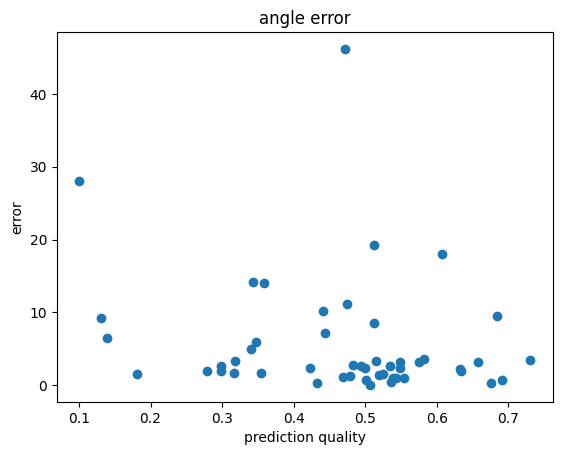

In [71]:
plt.scatter(results_classic['predicted_angle_quality'], results_classic['angle_error'])
plt.xlabel('prediction quality')
plt.ylabel('error')
plt.title('angle error');


#### lumen fraction

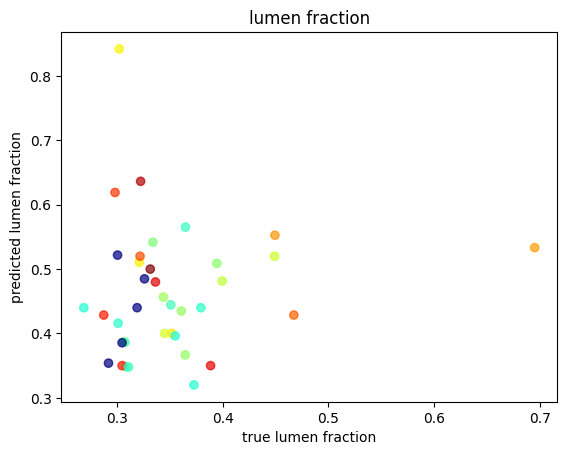

In [73]:
plt.scatter(results_classic['granum_lumen_fraction'], results_classic['predicted_lumen_fraction'], c=1e-2 + 1-results_classic['predicted_period_quality'], cmap='jet', alpha=0.7, norm=matplotlib.colors.LogNorm())
plt.xlabel('true lumen fraction')
plt.ylabel('predicted lumen fraction')
plt.colorbar()
plt.title('lumen fraction');


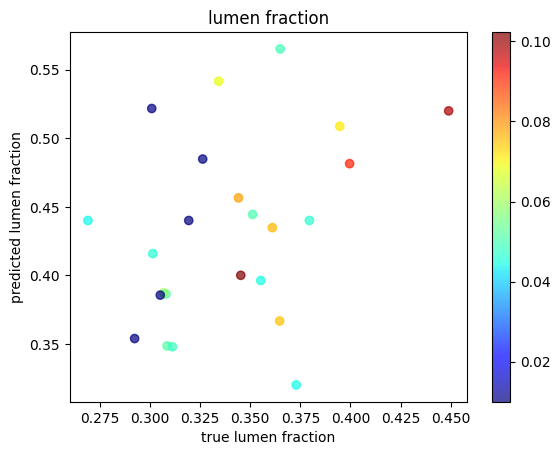

In [76]:
mask = results_classic['predicted_period_quality']>0.9
plt.scatter(results_classic['granum_lumen_fraction'].loc[mask], results_classic['predicted_lumen_fraction'].loc[mask], c=1e-2 + 1-results_classic['predicted_period_quality'].loc[mask], cmap='jet', alpha=0.7)
plt.xlabel('true lumen fraction')
plt.ylabel('predicted lumen fraction')
plt.colorbar()
plt.title('lumen fraction');


## Comparison

In [49]:
def remove_nans(x):
    return x[np.isfinite(x)]

Text(0.5, 1.0, 'lumen fraction error')

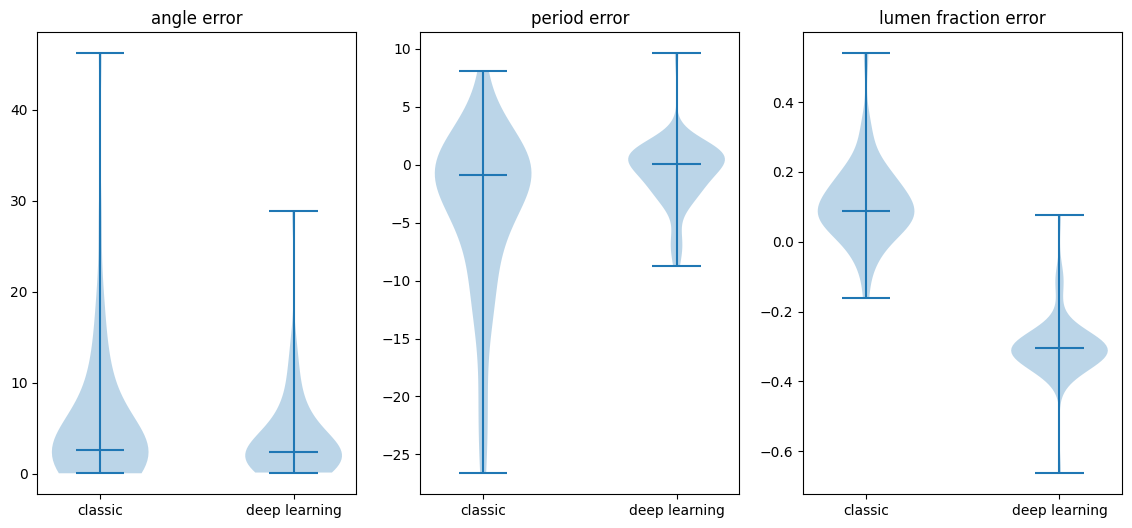

In [50]:
fig, axs = plt.subplots(figsize=(14,6), ncols=3)

# plot violin plot
axs[0].violinplot([results_classic['angle_error'], results['angle_error']],
                  showmeans=False,
                  showmedians=True)
axs[0].set_xticks([y + 1 for y in range(2)],
              labels=['classic', 'deep learning']);
axs[0].set_title('angle error')

axs[1].violinplot([remove_nans(results_classic['predicted_period'] - results_classic['period']), remove_nans(results['predicted_period'] - results['period'])],
                  showmeans=False,
                  showmedians=True)
axs[1].set_xticks([y + 1 for y in range(2)],
              labels=['classic', 'deep learning']);
axs[1].set_title('period error')

axs[2].violinplot([remove_nans(results_classic['predicted_lumen_fraction'] - results_classic['granum_lumen_fraction']), remove_nans(results['predicted_lumen_fraction'] - results['granum_lumen_fraction'])],
                  showmeans=False,
                  showmedians=True)
axs[2].set_xticks([y + 1 for y in range(2)],
              labels=['classic', 'deep learning']);
axs[2].set_title('lumen fraction error')

In [92]:
results.to_csv('real_imgs_preds_DL_20231031.csv', index=False)
results_classic.to_csv('real_imgs_preds_classic_20231031.csv', index=False)